In [1]:
import pandas as pd
import cvxpy as cp
import timeit
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
SMALL_SIZE = 24
MEDIUM_SIZE = 26
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

# June and December 2019

In [40]:
def Cost(C_i, i=0.04/12, periods=20*12): # i = interest rate per month, periods = payback periods (months), can change timescale to not be months
    fv = C_i*((1+i)**periods) #future value calculation
    cost = fv*(i/(((1+i)**periods) - 1))*(1/(1+i)) # monthly payment
    return cost

def GridCost(cg, mon, t, cost, c_fix):
    if (mon=="june"):
        df = pd.read_excel ('houston pricing 2019.xlsx', sheet_name='Jun')
        if (cost=="fixed"):
            for n in range (0, t):
                cg += [c_fix] 
        elif (cost=="wholesale"):
            for n in range (0, t):
                cg += [df.at[n, "Settlement Point Price"]]
        else:
            print('invalid cost input. must be "fixed" or "wholesale"')
            return 0
    elif (mon=="december"):
        if (cost=="fixed"):
            for n in range (0, t):
                cg += [c_fix] 
        elif (cost=="wholesale"):
            df = pd.read_excel ('houston pricing 2019.xlsx', sheet_name='Dec')
            for n in range (0, t):
                cg += [df.at[n, "Settlement Point Price"]]
        else:
            print('invalid cost input. must be "fixed" or "wholesale"')
            return 0
    else:
        print('invalid month input. must be "june" or "december"')
        return 0
    return cg
    
def Loads(pl, t):
    df_loads = pd.read_excel(r'ethylene 14.xlsx')
    for hour in range(t):
        pl += [df_loads.at[hour, 'P_L_s']]
    return pl

def Solar(ps, mon, t):
    if (mon=="june"):
        df_solar = pd.read_excel('pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='j')
        for hour in range(t):
            ps += [df_solar.at[hour, "ACMW"]] 
    elif (mon=="december"):
        df_solar = pd.read_excel('pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='d')
        for hour in range(t):
            ps += [df_solar.at[hour, "ACMW"]] 
    else:
        print('invalid month input. must be "june" or "december"')
        return 0
    return ps

def SellPrice_e(month, sp):
    if (month=="june"):
        df = pd.read_excel ('Mont Belvieu Ethylene Prices.xlsx', sheet_name='june')
        for n in range (0, 30):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                sp += temp
    elif (month=="december"):
        df = pd.read_excel ('Mont Belvieu Ethylene Prices.xlsx', sheet_name='december')
        for n in range (0, 31):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                sp += temp
    else:
        print("invalid month input")
        return 0
    return sp

def SellPrice_h(month, sp):
    if (month=="june"):
        for n in range (0, 30):
            for m in range (0, 24):
                sp += [3000]
    elif (month=="december"):
        for n in range (0, 31):
            for m in range (0, 24):
                sp += [3000]
    else:
        print("invalid month input")
        return 0
    return sp

def BuyPrice(month, bp):
    if (month=="june"):
        df = pd.read_excel ('Mont Belvieu Ethane Prices CV.xlsx', sheet_name='june')
        for n in range (0, 30):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                bp += temp
    elif (month=="december"):
        df = pd.read_excel ('Mont Belvieu Ethane Prices CV.xlsx', sheet_name='december')
        for n in range (0, 31):
            temp = [df.at[n, "$/ton"]] # cost per Mwh of solar
            for m in range (0, 24):
                bp += temp
    else:
        print("invalid month input")
        return 0
    return bp

# N = 4

In [41]:
N = 4 # horizon length # do 1, 4, 24

## June

In [49]:
start = timeit.default_timer()
 
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min # [MW/hr]
eff = 0.95 # battery efficiency
t = 720 # one month duration # [hours]
month = "june" # or "december"
cost = "wholesale" # "fixed" 
c_fix = 19.75 # june 19.75, december 21.19 # [$/MWh]
storage_limit_e = 250 # [mt]
storage_limit_h = 250 # [mt]
storage_limit_f = 750  # [mt]
outage = "no" # or "yes"
op_c = 85.75 # operational cost # [$]
pc_multiplier = 1
# outage_duration = 4 # [hours] # if outage = yes
# outage_start = 100 # [hour] # if outage = yes
battery_duration = 4 # 1 hour battery, 4 hour battery, etc

E_max_stor = []
prob_stor = []
C_b_stor = []
S_max_stor = []
P_c_stor = []
S_l_e_stor = []
S_l_h_stor = []
Pd_e_stor = []
C_g_stor = []
C_s_stor = []
St_e_stor = []
St_f_stor = []
E_b_i = 0
St_e_i = 0
St_h_i = 0
St_f_i = 0

P_L = [] # loads # MW
P_L = Loads(P_L, t)
P_s = [] # power generated by solar # MW
P_s = Solar(P_s, month, t)
S_p_e = [] # sell price # [$/mt]
S_p_e = SellPrice_e(month, S_p_e) 
S_p_h = [] # sell price # [$/mt]
S_p_h = SellPrice_h(month, S_p_h)
B_p = [] # buy price # [$/mt]
B_p = BuyPrice(month, B_p)
C_gr = [] # cost of power from the grid #[$/mt]
C_gr = GridCost(C_gr, month, t, cost, c_fix)

# plt.plot(P_L, label="P_L")
# plt.plot(P_s, label="P_s")
# plt.plot(S_p_e, label="se")
# plt.plot(S_p_h, label="sh")
# plt.plot(B_p, label="bp")
# plt.plot(C_gr, label="cg")
# plt.legend()
# plt.show()

assert 0 < eff <= 1.0, "efficiency must be between (0,1]"

for m in range(t-24): 
    sta = timeit.default_timer()
    
    E_max = cp.Variable() # establishing battery capacity (MW (h?))
    E_b = cp.Variable(N+1) # defining battery charge variable
    P_g = cp.Variable(N) # power drawn from the grid
    P_ch = cp.Variable(N) # battery charge
    P_dis = cp.Variable(N) # battery discharge []
    S_max = cp.Variable() # size of the solar panels 
    St_e = cp.Variable(N+1) # ethylene storage [mt]
    Sl_e = cp.Variable(N) # sold ethylene [mt]
    St_h = cp.Variable(N+1) # hydrogen storage [mt]
    Sl_h = cp.Variable(N) # sold hydrogen [mt]
    St_f = cp.Variable(N+1) # feedstock storage [mt]
    Bt_f = cp.Variable(N+1) # bought feedstock [mt]
    Pd_e = cp.Variable(N) # production of ethylene [mt]
    Pd_h = cp.Variable(N) # production of hydrogen [mt]
    Pd_f = cp.Variable(N) # production of feedstock [mt]

    C_s = S_max*Cost(1000000*0.89*20) # [$]
    C_b = E_max*(Cost(87000)) # [$]
    C_g = []
    for n in range(N):
        C_g += [(C_gr[m+n])*P_g[n]]  
    
    constraints = []   
    constraints += [P_g >= 0] # power draw is not negative # [MW >= MW]
    constraints += [P_L[m:N+m] == P_g + P_dis + -P_ch + P_s[m:N+m]*S_max] # the sources sum to load requirements # [MW = MW + MW + MW + MW]
    constraints += [E_b[0] == E_b_i] # battery charge at start is zero # [MW = MW]
    constraints += [P_ch >= 0] # charge into the is not negative # [MW >= MW]
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    constraints += [S_max >= 0] # can't have negative solar capacity 
    constraints += [S_max <= 1] # solar 20000 kW or less
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    for n in range (0, N-1):     # ramp value constraints - power change between time steps can't exceed ramp limit
        constraints += [(P_g[n] - P_g[n+1]) <= P_ramp] # [MW - MW <= MW]
        constraints += [(P_g[n] - P_g[n+1]) >= -P_ramp]  # [MW - MW >= MW]
    constraints += [St_e[0] == St_e_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_h[0] == St_h_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_f[0] == St_f_i] # storage empty at start # [mt = mt]
    
    for n in range (0, N):
        constraints += [E_max/battery_duration >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity #[MW=MW]
        constraints += [E_max/battery_duration >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy #[MW=MW]
        constraints += [St_e[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_h[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_f[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit # [mt = mt]
        constraints += [Sl_e[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Sl_e <= St_e[n]+Pd_e[n]] # sold ethylene less than produced # [mt = mt]
        constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Sl_h[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Pd_h[n] == Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    #     constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Bt_f[n] >= 0] # buying not selling # [mt = mt]
        constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep # [mt = mt]
    
    if N == 1: # no MPC - no way to use storage
        constraints += [St_h == 0, E_b == 0, St_e == 0, St_f == 0]
        constraints += [Bt_f == Pd_f]
        constraints += [Pd_h == Sl_h]
        constraints += [Pd_e == Sl_e]
    else:
        for n in range (1, N+1):
            constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery # [Mw = MW + MW - MW]
            constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            # currently no hydrogen storage
            constraints += [St_h[n] == 0] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used # [mt = mt + mt - mt]
    
    for n in range (0, N+1):
        constraints += [E_b[n] >= 0] # battery charge is not negative # [MW >= MW]
        constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity  # [MW >= MW]
    
    if (outage=="yes"):
        for n in range (outage_start, outage_start + outage_duration):
            constraints += [P_g[n] == 0] # [MW = MW]   
            constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt >= 1/MW*mt*MW]
            constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt <= 1/MW*mt*MW]
        for n in range(0, outage_start):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
        for n in range(outage_start + outage_duration, t):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    elif (outage=="no"):
        for n in range(0, N):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    
    for n in range(0, N):
        constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05] # hydrogen mol/ethylene mol conversion # [mt = mt * mol/mol]
        constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05] # ethane mol/ethylene mol conversion # [mt = mt * mol/mol]
    P_c = [] # bought ethylene including price # [$ = $/mt * mt]
    S_l_e = [] # sold ethylene including price # [$ = $/mt * mt]
    S_l_h = [] # sold ethylene including price # [$ = $/mt * mt]
    for n in range(N):
        P_c += [Bt_f[n] * B_p[n+m]]
        S_l_e += [Sl_e[n] * S_p_e[n+m]]
        S_l_h += [Sl_h[n] * S_p_h[n+m]]
        
#     objective = op_c*sum(Pd_e) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
    sumpde = []
    for n in range((Pd_e).size):
        sumpde += [Pd_e[n]]

    objective = op_c*sum(sumpde) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
    
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve() 
#     print(prob.status)
    
    E_max_stor += [E_max.value]
    prob_stor += [prob.value]
    C_b_stor += [C_b.value]
    S_max_stor += [S_max.value]
    P_c_stor += [P_c[0].value]
    S_l_e_stor += [S_l_e[0].value]
    S_l_h_stor += [S_l_h[0].value]
    E_b_i = E_b[1].value
    St_e_i = St_e[1].value
    St_h_i = St_h[1].value
    St_f_i = St_f[1].value
    Pd_e_stor += [Pd_e[0].value]
    C_g_stor += [C_g[0].value]
    C_s_stor += [C_s.value]
    St_e_stor += [St_e[0].value]
    St_f_stor += [St_f[0].value]
    
    sto = timeit.default_timer()
#     print("Time (seconds):", sto-sta)
    
#     print("a:", E_max.value, "b:", E_b.value, "c:", P_g.value, "d:", P_ch.value, "e:", P_dis.value, "f:", S_max.value,  "g:", St_e.value, "h:", Sl_e.value, "i:", St_h.value, "j:", Sl_h.value, "k:", St_f.value, "l:", Bt_f.value, "m:", Pd_e.value, "n:", Pd_h.value, "o:", Pd_f.value)
    
    
#printing results
obj_tot = op_c*sum(Pd_e_stor) + sum(C_g_stor) + max(C_b_stor) + max(S_max_stor)*Cost(1000000*0.89*20) + sum(P_c_stor)*pc_multiplier - sum(S_l_e_stor) - sum(S_l_h_stor) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
print("Battery Capacity [MW]: ", max(E_max_stor))
print("Cost of Battery [$]: ", max(C_b_stor))
print("Solar Size [MW]: ", max(S_max_stor)*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c_stor))
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e_stor))
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h_stor))
print("Overall Profit", -obj_tot)
if 0 > obj_tot:
    print("Profit")
else:
    print("Loss")

stop = timeit.default_timer()

print('Time (seconds): ', stop - start) 

Battery Capacity [MW]:  6.16075036278558e-07
Cost of Battery [$]:  0.0003237174791569304
Solar Size [MW]:  -6.308302713267703e-11
Cost of Bought Ethane [tons]:  51120283.614799164
Cost of Sold Ethylene [tons]:  31362194.980296742
Cost of Sold Hydrogen [tons]:  20214162.481901526
Overall Profit -15422704.403234914
Loss
Time (seconds):  71.48559799999975


In [50]:
S_l_e_j = S_l_e_stor
S_l_h_j = S_l_h_stor
P_c_j = P_c_stor
C_s_j = C_s_stor
C_b_j = C_b_stor
C_g_j = C_g_stor
Pd_e_j = Pd_e_stor
St_e_j = St_e_stor
St_f_j = St_f_stor

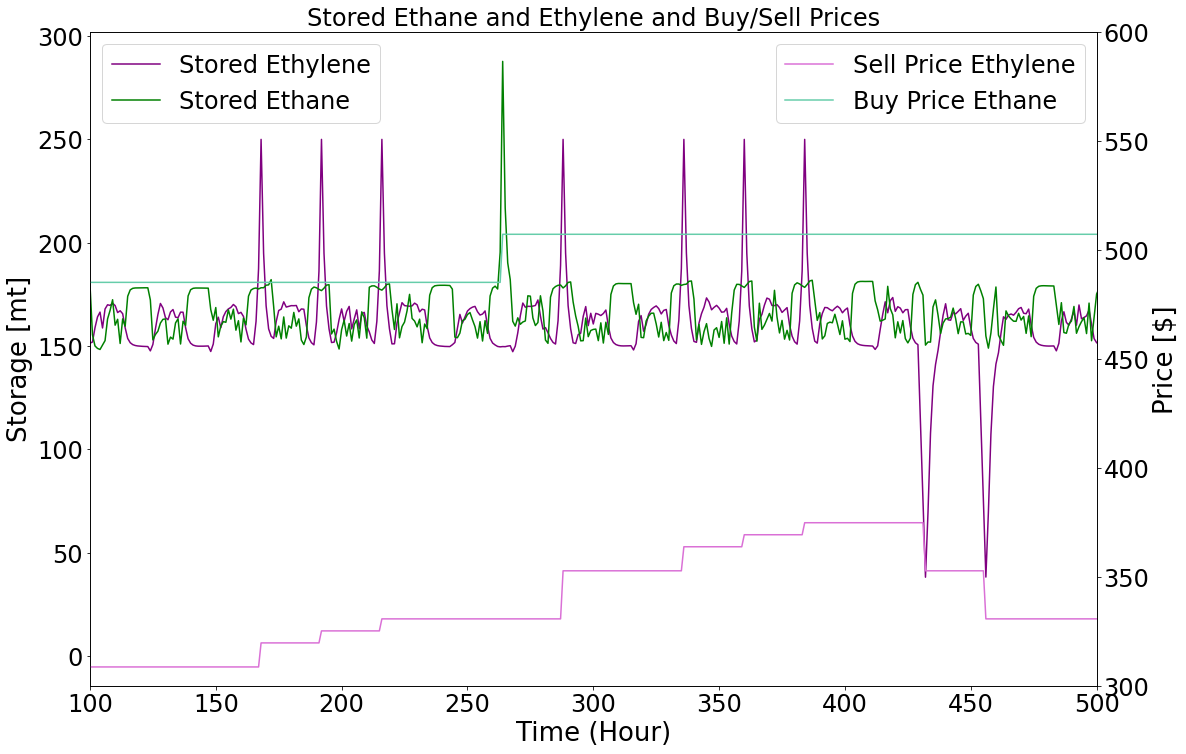

In [51]:
fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene")
ax.plot(St_f_j, color="green", label="Stored Ethane")
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
ax.set_xlim([100, 500])
ax2.set_ylim([300, 600])
plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
plt.tight_layout()
plt.show()

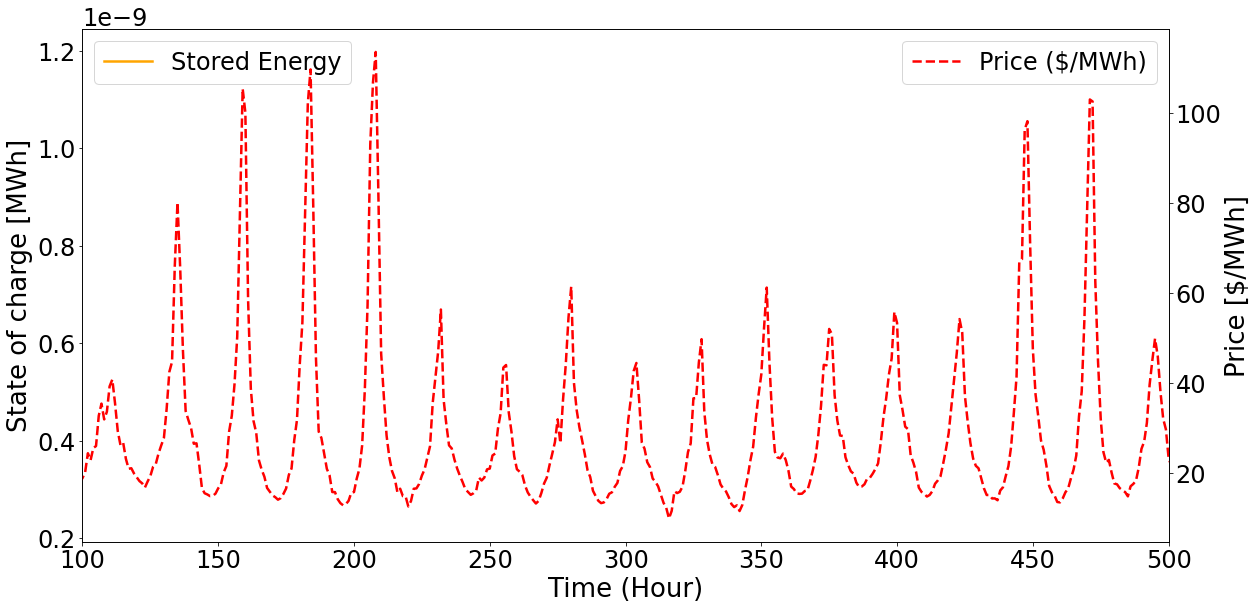

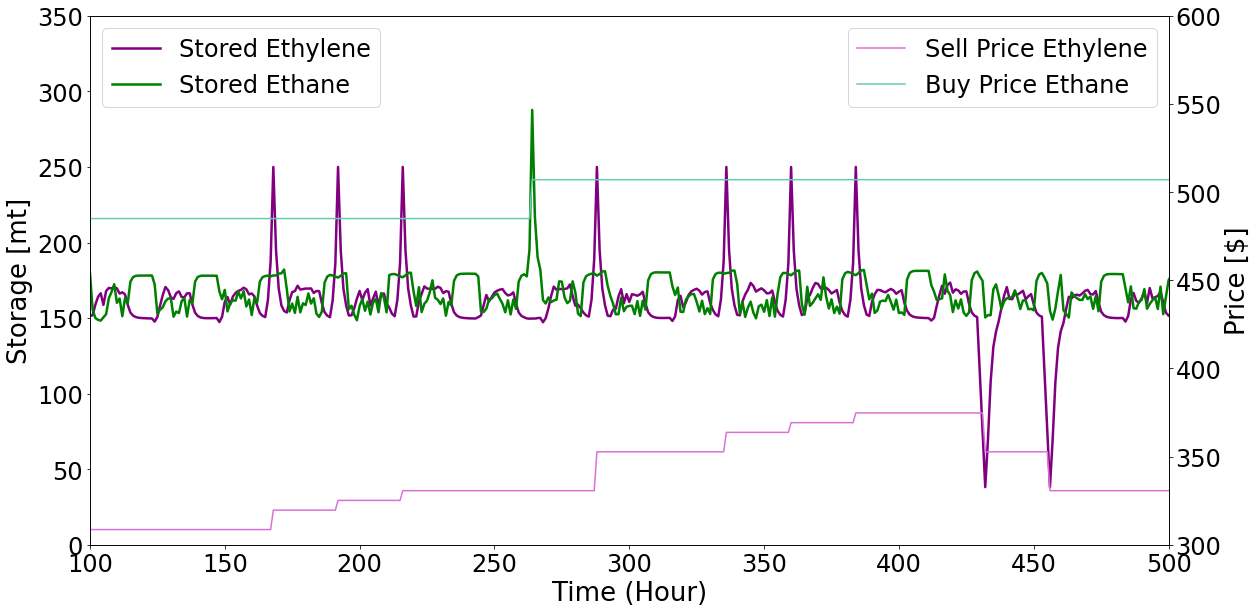

In [57]:
# battery state of charge and electricity price - 
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('State of charge [MWh]')
ax2.set_ylabel('Price [$/MWh]')
ax.plot(E_b.value, color="orange", label="Stored Energy", linewidth=2.5)
ax2.plot(C_gr, color="red", label="Electricity Price", linestyle='dashed', linewidth=2.5, )
ax.legend(['Stored Energy', 'Electricity Price'], loc='upper left')
ax2.legend(['Price ($/MWh)'], loc='upper right')
plt.tight_layout()
#plt.title("Battery state of charge and wholesale electricity prices")
ax.set_xlim([100, 500])
#ax.set_ylim([-5, max(E_b.value)+10])
plt.show()
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene", linewidth=2.5)
ax.plot(St_f_j, color="green", label="Stored Ethane", linewidth=2.5)
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
plt.tight_layout()
#plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
ax.set_xlim([100, 500])
ax.set_ylim([0, 350])
ax2.set_ylim([300, 600])
plt.show()

## December

In [58]:
start = timeit.default_timer()
 
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min # [MW/hr]
eff = 0.95 # battery efficiency
t = 720 # one month duration # [hours]
month = "december" # or "june"
cost = "wholesale" # "fixed" 
c_fix = 19.75 # june 19.75, december 21.19 # [$/MWh]
storage_limit_e = 250 # [mt]
storage_limit_h = 250 # [mt]
storage_limit_f = 750  # [mt]
outage = "no" # or "yes"
op_c = 85.75 # operational cost # [$]
pc_multiplier = 1
# outage_duration = 4 # [hours] # if outage = yes
# outage_start = 100 # [hour] # if outage = yes
battery_duration = 4 # 1 hour battery, 4 hour battery, etc

E_max_stor = []
prob_stor = []
C_b_stor = []
S_max_stor = []
P_c_stor = []
S_l_e_stor = []
S_l_h_stor = []
Pd_e_stor = []
C_g_stor = []
C_s_stor = []
St_e_stor = []
St_f_stor = []
E_b_i = 0
St_e_i = 0
St_h_i = 0
St_f_i = 0

P_L = [] # loads # MW
P_L = Loads(P_L, t)
P_s = [] # power generated by solar # MW
P_s = Solar(P_s, month, t)
S_p_e = [] # sell price # [$/mt]
S_p_e = SellPrice_e(month, S_p_e) 
S_p_h = [] # sell price # [$/mt]
S_p_h = SellPrice_h(month, S_p_h)
B_p = [] # buy price # [$/mt]
B_p = BuyPrice(month, B_p)
C_gr = [] # cost of power from the grid #[$/mt]
C_gr = GridCost(C_gr, month, t, cost, c_fix)

# plt.plot(P_L, label="P_L")
# plt.plot(P_s, label="P_s")
# plt.plot(S_p_e, label="se")
# plt.plot(S_p_h, label="sh")
# plt.plot(B_p, label="bp")
# plt.plot(C_gr, label="cg")
# plt.legend()
# plt.show()

assert 0 < eff <= 1.0, "efficiency must be between (0,1]"

for m in range(t-24): 
    sta = timeit.default_timer()
    
    E_max = cp.Variable() # establishing battery capacity (MW)
    E_b = cp.Variable(N+1) # defining battery charge variable
    P_g = cp.Variable(N) # power drawn from the grid
    P_ch = cp.Variable(N) # battery charge
    P_dis = cp.Variable(N) # battery discharge []
    S_max = cp.Variable() # size of the solar panels 
    St_e = cp.Variable(N+1) # ethylene storage [mt]
    Sl_e = cp.Variable(N) # sold ethylene [mt]
    St_h = cp.Variable(N+1) # hydrogen storage [mt]
    Sl_h = cp.Variable(N) # sold hydrogen [mt]
    St_f = cp.Variable(N+1) # feedstock storage [mt]
    Bt_f = cp.Variable(N+1) # bought feedstock [mt]
    Pd_e = cp.Variable(N) # production of ethylene [mt]
    Pd_h = cp.Variable(N) # production of hydrogen [mt]
    Pd_f = cp.Variable(N) # production of feedstock [mt]

    C_s = S_max*Cost(1000000*0.89*20) # [$]
    C_b = E_max*(Cost(87000)) # [$]
    C_g = []
    for n in range(N):
        C_g += [(C_gr[m+n])*P_g[n]]  
    
    constraints = []   
    constraints += [P_g >= 0] # power draw is not negative # [MW >= MW]
    constraints += [P_L[m:N+m] == P_g + P_dis + -P_ch + P_s[m:N+m]*S_max] # the sources sum to load requirements # [MW = MW + MW + MW + MW]
    constraints += [E_b[0] == E_b_i] # battery charge at start is zero # [MW = MW]
    constraints += [P_ch >= 0] # charge into the is not negative # [MW >= MW]
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    constraints += [S_max >= 0] # can't have negative solar capacity 
    constraints += [S_max <= 1] # solar 20000 kW or less
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    for n in range (0, N-1):     # ramp value constraints - power change between time steps can't exceed ramp limit
        constraints += [(P_g[n] - P_g[n+1]) <= P_ramp] # [MW - MW <= MW]
        constraints += [(P_g[n] - P_g[n+1]) >= -P_ramp]  # [MW - MW >= MW]
    constraints += [St_e[0] == St_e_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_h[0] == St_h_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_f[0] == St_f_i] # storage empty at start # [mt = mt]
    
    for n in range (0, N):
        constraints += [E_max/battery_duration >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity #[MW=MW]
        constraints += [E_max/battery_duration >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy #[MW=MW]
        constraints += [St_e[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_h[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_f[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit # [mt = mt]
        constraints += [Sl_e[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Sl_e <= St_e[n]+Pd_e[n]] # sold ethylene less than produced # [mt = mt]
        constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Sl_h[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Pd_h[n] == Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    #     constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Bt_f[n] >= 0] # buying not selling # [mt = mt]
        constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep # [mt = mt]
    
    if N == 1: # no MPC - no way to use storage
        constraints += [St_h == 0, E_b == 0, St_e == 0, St_f == 0]
        constraints += [Bt_f == Pd_f]
        constraints += [Pd_h == Sl_h]
        constraints += [Pd_e == Sl_e]
    else:
        for n in range (1, N+1):
            constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery # [Mw = MW + MW - MW]
            constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            # currently no hydrogen storage
            constraints += [St_h[n] == 0] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used # [mt = mt + mt - mt]
    
    for n in range (0, N+1):
        constraints += [E_b[n] >= 0] # battery charge is not negative # [MW >= MW]
        constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity  # [MW >= MW]
    
    if (outage=="yes"):
        for n in range (outage_start, outage_start + outage_duration):
            constraints += [P_g[n] == 0] # [MW = MW]   
            constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt >= 1/MW*mt*MW]
            constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt <= 1/MW*mt*MW]
        for n in range(0, outage_start):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
        for n in range(outage_start + outage_duration, t):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    elif (outage=="no"):
        for n in range(0, N):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    
    for n in range(0, N):
        constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05] # hydrogen mol/ethylene mol conversion # [mt = mt * mol/mol]
        constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05] # ethane mol/ethylene mol conversion # [mt = mt * mol/mol]
    P_c = [] # bought ethylene including price # [$ = $/mt * mt]
    S_l_e = [] # sold ethylene including price # [$ = $/mt * mt]
    S_l_h = [] # sold ethylene including price # [$ = $/mt * mt]
    for n in range(N):
        P_c += [Bt_f[n] * B_p[n+m]]
        S_l_e += [Sl_e[n] * S_p_e[n+m]]
        S_l_h += [Sl_h[n] * S_p_h[n+m]]

    sumpde = []
    for n in range((Pd_e).size):
        sumpde += [Pd_e[n]]

    objective = op_c*sum(sumpde) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
#     objective = op_c*sum(Pd_e) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve() 
#     print(prob.status)
    
    E_max_stor += [E_max.value]
    prob_stor += [prob.value]
    C_b_stor += [C_b.value]
    S_max_stor += [S_max.value]
    P_c_stor += [P_c[0].value]
    S_l_e_stor += [S_l_e[0].value]
    S_l_h_stor += [S_l_h[0].value]
    E_b_i = E_b[1].value
    St_e_i = St_e[1].value
    St_h_i = St_h[1].value
    St_f_i = St_f[1].value
    Pd_e_stor += [Pd_e[0].value]
    C_g_stor += [C_g[0].value]
    C_s_stor += [C_s.value]
    St_e_stor += [St_e[0].value]
    St_f_stor += [St_f[0].value]
    
    sto = timeit.default_timer()
#     print("Time (seconds):", sto-sta)
    
#     print("a:", E_max.value, "b:", E_b.value, "c:", P_g.value, "d:", P_ch.value, "e:", P_dis.value, "f:", S_max.value,  "g:", St_e.value, "h:", Sl_e.value, "i:", St_h.value, "j:", Sl_h.value, "k:", St_f.value, "l:", Bt_f.value, "m:", Pd_e.value, "n:", Pd_h.value, "o:", Pd_f.value)
    
    
#printing results
obj_tot = op_c*sum(Pd_e_stor) + sum(C_g_stor) + max(C_b_stor) + max(S_max_stor)*Cost(1000000*0.89*20) + sum(P_c_stor)*pc_multiplier - sum(S_l_e_stor) - sum(S_l_h_stor) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
print("Battery Capacity [MW]: ", max(E_max_stor))
print("Cost of Battery [$]: ", max(C_b_stor))
print("Solar Size [MW]: ", max(S_max_stor)*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c_stor))
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e_stor))
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h_stor))
print("Overall Profit", -obj_tot)
if 0 > obj_tot:
    print("Profit")
else:
    print("Loss")

stop = timeit.default_timer()

print('Time (seconds): ', stop - start) 

Battery Capacity [MW]:  9.851749556520995e-07
Cost of Battery [$]:  0.0005176615418451066
Solar Size [MW]:  -7.610515746116278e-12
Cost of Bought Ethane [tons]:  40023387.1529021
Cost of Sold Ethylene [tons]:  34759220.68368917
Cost of Sold Hydrogen [tons]:  20214162.481835537
Overall Profit 1508530.2918165177
Profit
Time (seconds):  71.47504470000013


In [59]:
S_l_e_d = S_l_e_stor
S_l_h_d = S_l_h_stor
P_c_d = P_c_stor
C_s_d = C_s_stor
C_b_d = C_b_stor
C_g_d = C_g_stor
Pd_e_d = Pd_e_stor
St_e_d = St_e_stor
St_f_d = St_f_stor

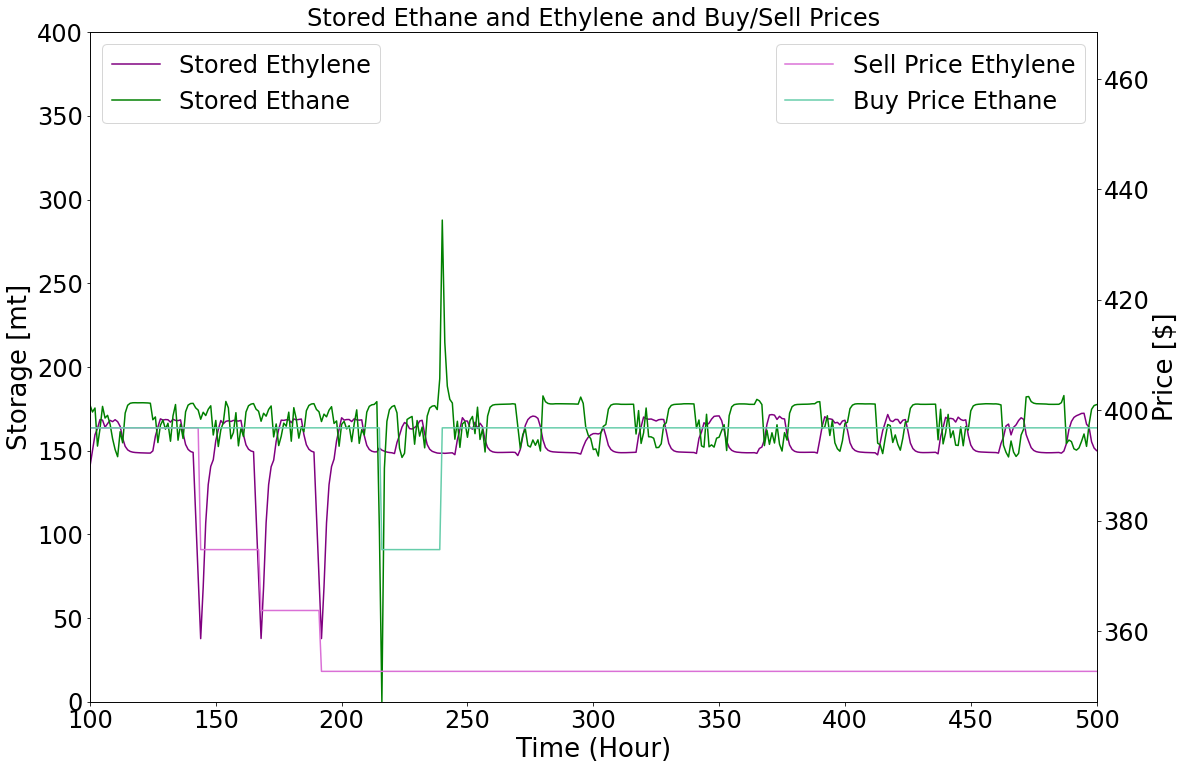

In [62]:
fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_d, color="purple", label="Stored Ethylene")
ax.plot(St_f_d, color="green", label="Stored Ethane")
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
ax.set_xlim([100, 500])
ax.set_ylim([0, 400])
plt.tight_layout()
plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
plt.show()

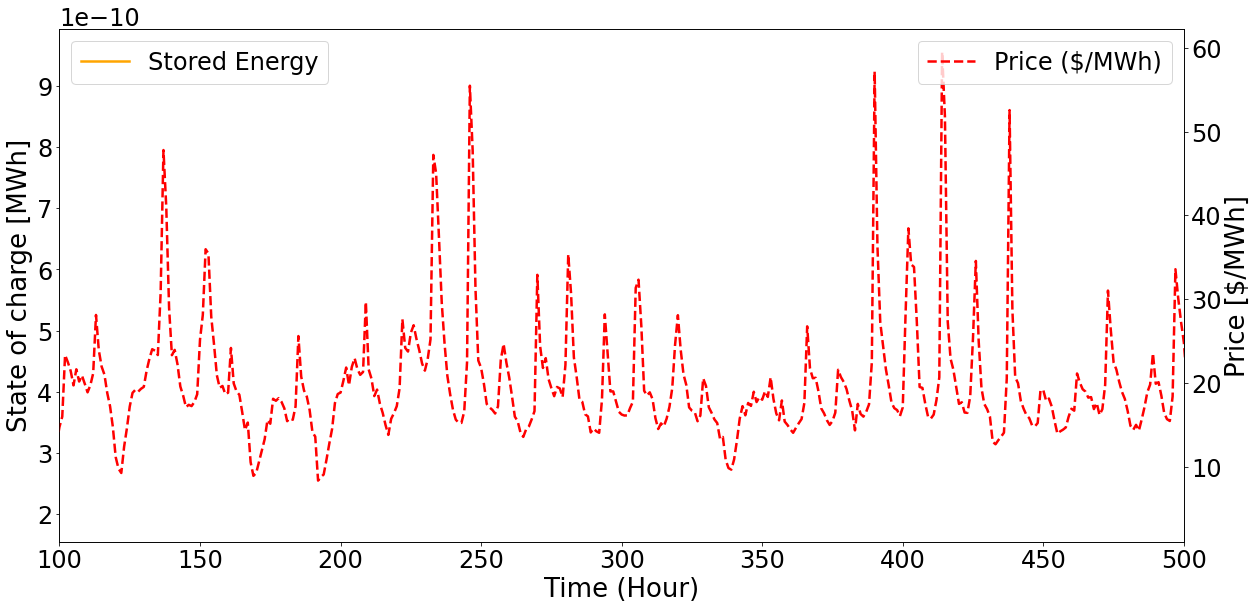

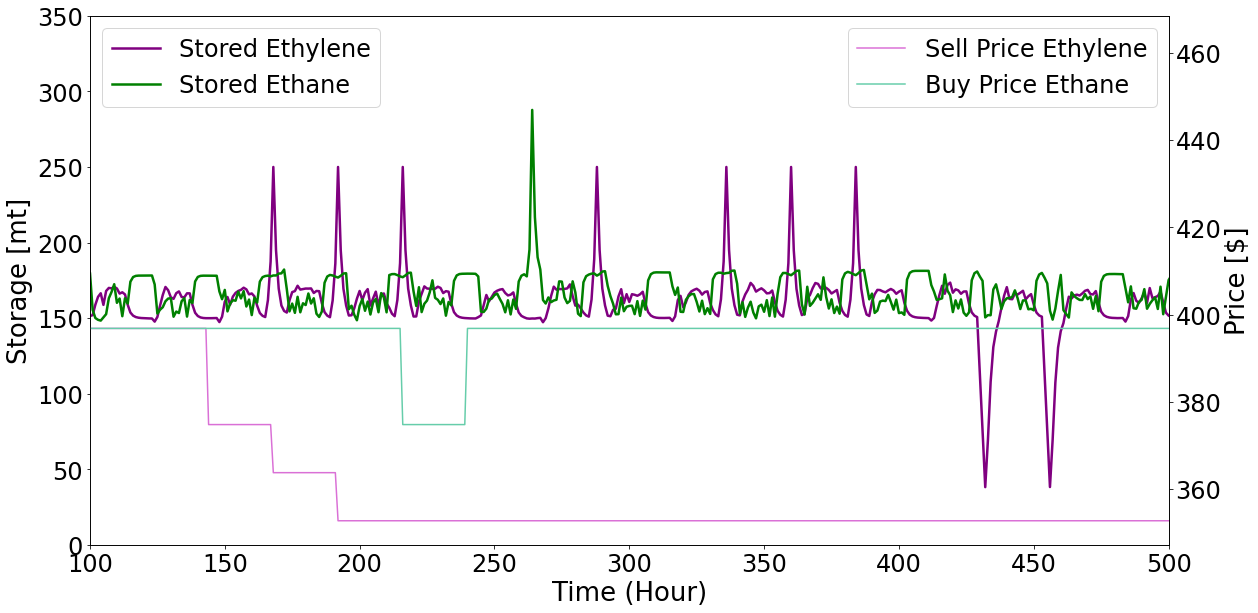

In [64]:
# battery state of charge and electricity price - 
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('State of charge [MWh]')
ax2.set_ylabel('Price [$/MWh]')
ax.plot(E_b.value, color="orange", label="Stored Energy", linewidth=2.5)
ax2.plot(C_gr, color="red", label="Electricity Price", linestyle='dashed', linewidth=2.5, )
ax.legend(['Stored Energy', 'Electricity Price'], loc='upper left')
ax2.legend(['Price ($/MWh)'], loc='upper right')
plt.tight_layout()
#plt.title("Battery state of charge and wholesale electricity prices")
ax.set_xlim([100, 500])
#ax.set_ylim([-5, max(E_b.value)+10])
plt.show()
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene", linewidth=2.5)
ax.plot(St_f_j, color="green", label="Stored Ethane", linewidth=2.5)
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
plt.tight_layout()
#plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
ax.set_xlim([100, 500])
ax.set_ylim([0, 350])
plt.show()

# Plotting

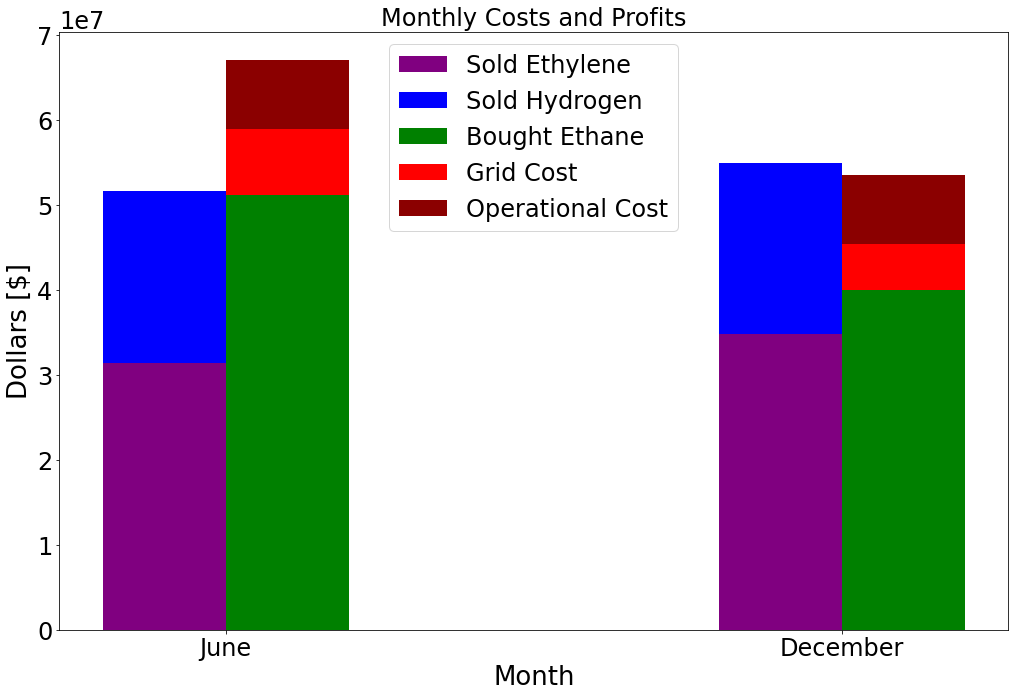

In [13]:
from pylab import *
fig, ax = plt.subplots(figsize=(17,11))
width = 0.5

ax.bar(0, sum(S_l_e_j), width, color="purple", align='edge', label="Sold Ethylene")
ax.bar(0, sum(S_l_h_j), width, color="blue", align='edge', bottom=sum(S_l_e_j), label="Sold Hydrogen")
ax.bar(0.5, sum(P_c_j)*pc_multiplier, width, color="green", align='edge', label="Bought Ethane")
# ax.bar(0.5, max(C_s_j), width, color="gold", align='edge', bottom=sum(P_c_j)*pc_multiplier, label="solar cost june")
# ax.bar(0.5, max(C_b_j), width, color="orange", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j, label="battery cost june")
ax.bar(0.5, sum(C_g_j), width, color="red", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j, label="Grid Cost")
ax.bar(0.5, op_c*sum(Pd_e_j), width, color="darkred", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j+sum(C_g_j), label="Operational Cost")

ax.bar(2.5, sum(S_l_e_d), width, color="purple", align='edge')
ax.bar(2.5, sum(S_l_h_d), width, color="blue", align='edge', bottom=sum(S_l_e_d))
ax.bar(3, sum(P_c_d)*pc_multiplier, width, color="green", align='edge')
# ax.bar(2.5, max(C_s_d), width, color="gold", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier, label="solar cost december")
# ax.bar(2.5, max(C_b_d), width, color="orange", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d, label="battery cost december")
ax.bar(3, sum(C_g_d), width, color="red", align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d)
ax.bar(3, op_c*sum(Pd_e_d), width, color="darkred", align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d+sum(C_g_d))

ax.set_ylabel('Dollars [$]')
ax.set_xlabel('Month')

x1 = [0.5,3]
labels = ['June', 'December']
ax.set_xticks(x1)
ax.set_xticklabels(labels, minor=False)

ax.set_title('Monthly Costs and Profits')
ax.legend(loc="upper center")
plt.show()

# N = 24

In [14]:
N = 24 # horizon length # do 1, 4, 24

## June

In [15]:
start = timeit.default_timer()
 
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min # [MW/hr]
eff = 0.95 # battery efficiency
t = 720 # one month duration # [hours]
month = "june" # or "december"
cost = "wholesale" # "fixed" 
c_fix = 19.75 # june 19.75, december 21.19 # [$/MWh]
storage_limit_e = 250 # [mt]
storage_limit_h = 250 # [mt]
storage_limit_f = 750  # [mt]
outage = "no" # or "yes"
op_c = 85.75 # operational cost # [$]
pc_multiplier = 1
# outage_duration = 4 # [hours] # if outage = yes
# outage_start = 100 # [hour] # if outage = yes
battery_duration = 4 # 1 hour battery, 4 hour battery, etc

E_max_stor = []
prob_stor = []
C_b_stor = []
S_max_stor = []
P_c_stor = []
S_l_e_stor = []
S_l_h_stor = []
Pd_e_stor = []
C_g_stor = []
C_s_stor = []
St_e_stor = []
St_f_stor = []
E_b_i = 0
St_e_i = 0
St_h_i = 0
St_f_i = 0

P_L = [] # loads # MW
P_L = Loads(P_L, t)
P_s = [] # power generated by solar # MW
P_s = Solar(P_s, month, t)
S_p_e = [] # sell price # [$/mt]
S_p_e = SellPrice_e(month, S_p_e) 
S_p_h = [] # sell price # [$/mt]
S_p_h = SellPrice_h(month, S_p_h)
B_p = [] # buy price # [$/mt]
B_p = BuyPrice(month, B_p)
C_gr = [] # cost of power from the grid #[$/mt]
C_gr = GridCost(C_gr, month, t, cost, c_fix)

# plt.plot(P_L, label="P_L")
# plt.plot(P_s, label="P_s")
# plt.plot(S_p_e, label="se")
# plt.plot(S_p_h, label="sh")
# plt.plot(B_p, label="bp")
# plt.plot(C_gr, label="cg")
# plt.legend()
# plt.show()

assert 0 < eff <= 1.0, "efficiency must be between (0,1]"

for m in range(t-24): 
    sta = timeit.default_timer()
    
    E_max = cp.Variable() # establishing battery capacity (MW)
    E_b = cp.Variable(N+1) # defining battery charge variable
    P_g = cp.Variable(N) # power drawn from the grid
    P_ch = cp.Variable(N) # battery charge
    P_dis = cp.Variable(N) # battery discharge []
    S_max = cp.Variable() # size of the solar panels 
    St_e = cp.Variable(N+1) # ethylene storage [mt]
    Sl_e = cp.Variable(N) # sold ethylene [mt]
    St_h = cp.Variable(N+1) # hydrogen storage [mt]
    Sl_h = cp.Variable(N) # sold hydrogen [mt]
    St_f = cp.Variable(N+1) # feedstock storage [mt]
    Bt_f = cp.Variable(N+1) # bought feedstock [mt]
    Pd_e = cp.Variable(N) # production of ethylene [mt]
    Pd_h = cp.Variable(N) # production of hydrogen [mt]
    Pd_f = cp.Variable(N) # production of feedstock [mt]

    C_s = S_max*Cost(1000000*0.89*20) # [$]
    C_b = E_max*(Cost(87000)) # [$]
    C_g = []
    for n in range(N):
        C_g += [(C_gr[m+n])*P_g[n]]  
    
    constraints = []   
    constraints += [P_g >= 0] # power draw is not negative # [MW >= MW]
    constraints += [P_L[m:N+m] == P_g + P_dis + -P_ch + P_s[m:N+m]*S_max] # the sources sum to load requirements # [MW = MW + MW + MW + MW]
    constraints += [E_b[0] == E_b_i] # battery charge at start is zero # [MW = MW]
    constraints += [P_ch >= 0] # charge into the is not negative # [MW >= MW]
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    constraints += [S_max >= 0] # can't have negative solar capacity 
    constraints += [S_max <= 1] # solar 20000 kW or less
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    for n in range (0, N-1):     # ramp value constraints - power change between time steps can't exceed ramp limit
        constraints += [(P_g[n] - P_g[n+1]) <= P_ramp] # [MW - MW <= MW]
        constraints += [(P_g[n] - P_g[n+1]) >= -P_ramp]  # [MW - MW >= MW]
    constraints += [St_e[0] == St_e_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_h[0] == St_h_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_f[0] == St_f_i] # storage empty at start # [mt = mt]
    
    for n in range (0, N):
        constraints += [E_max/battery_duration >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity #[MW=MW]
        constraints += [E_max/battery_duration >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy #[MW=MW]
        constraints += [St_e[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_h[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_f[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit # [mt = mt]
        constraints += [Sl_e[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Sl_e <= St_e[n]+Pd_e[n]] # sold ethylene less than produced # [mt = mt]
        constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Sl_h[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Pd_h[n] == Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    #     constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Bt_f[n] >= 0] # buying not selling # [mt = mt]
        constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep # [mt = mt]
    
    if N == 1: # no MPC - no way to use storage
        constraints += [St_h == 0, E_b == 0, St_e == 0, St_f == 0]
        constraints += [Bt_f == Pd_f]
        constraints += [Pd_h == Sl_h]
        constraints += [Pd_e == Sl_e]
    else:
        for n in range (1, N+1):
            constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery # [Mw = MW + MW - MW]
            constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            # currently no hydrogen storage
            constraints += [St_h[n] == 0] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used # [mt = mt + mt - mt]
    
    for n in range (0, N+1):
        constraints += [E_b[n] >= 0] # battery charge is not negative # [MW >= MW]
        constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity  # [MW >= MW]
    
    if (outage=="yes"):
        for n in range (outage_start, outage_start + outage_duration):
            constraints += [P_g[n] == 0] # [MW = MW]   
            constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt >= 1/MW*mt*MW]
            constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt <= 1/MW*mt*MW]
        for n in range(0, outage_start):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
        for n in range(outage_start + outage_duration, t):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    elif (outage=="no"):
        for n in range(0, N):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    
    for n in range(0, N):
        constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05] # hydrogen mol/ethylene mol conversion # [mt = mt * mol/mol]
        constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05] # ethane mol/ethylene mol conversion # [mt = mt * mol/mol]
    P_c = [] # bought ethylene including price # [$ = $/mt * mt]
    S_l_e = [] # sold ethylene including price # [$ = $/mt * mt]
    S_l_h = [] # sold ethylene including price # [$ = $/mt * mt]
    for n in range(N):
        P_c += [Bt_f[n] * B_p[n+m]]
        S_l_e += [Sl_e[n] * S_p_e[n+m]]
        S_l_h += [Sl_h[n] * S_p_h[n+m]]
        
    sumpde = []
    for n in range((Pd_e).size):
        sumpde += [Pd_e[n]]

    objective = op_c*sum(sumpde) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
    
#     objective = op_c*sum(Pd_e) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve() 
#     print(prob.status)
    
    E_max_stor += [E_max.value]
    prob_stor += [prob.value]
    C_b_stor += [C_b.value]
    S_max_stor += [S_max.value]
    P_c_stor += [P_c[0].value]
    S_l_e_stor += [S_l_e[0].value]
    S_l_h_stor += [S_l_h[0].value]
    E_b_i = E_b[1].value
    St_e_i = St_e[1].value
    St_h_i = St_h[1].value
    St_f_i = St_f[1].value
    Pd_e_stor += [Pd_e[0].value]
    C_g_stor += [C_g[0].value]
    C_s_stor += [C_s.value]
    St_e_stor += [St_e[0].value]
    St_f_stor += [St_f[0].value]
    
    sto = timeit.default_timer()
#     print("Time (seconds):", sto-sta)
    
#     print("a:", E_max.value, "b:", E_b.value, "c:", P_g.value, "d:", P_ch.value, "e:", P_dis.value, "f:", S_max.value,  "g:", St_e.value, "h:", Sl_e.value, "i:", St_h.value, "j:", Sl_h.value, "k:", St_f.value, "l:", Bt_f.value, "m:", Pd_e.value, "n:", Pd_h.value, "o:", Pd_f.value)
    
    
#printing results
obj_tot = op_c*sum(Pd_e_stor) + sum(C_g_stor) + max(C_b_stor) + max(S_max_stor)*Cost(1000000*0.89*20) + sum(P_c_stor)*pc_multiplier - sum(S_l_e_stor) - sum(S_l_h_stor) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
print("Battery Capacity [MW]: ", max(E_max_stor))
print("Cost of Battery [$]: ", max(C_b_stor))
print("Solar Size [MW]: ", max(S_max_stor)*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c_stor))
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e_stor))
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h_stor))
print("Overall Profit", -obj_tot)
if 0 > obj_tot:
    print("Profit")
else:
    print("Loss")

stop = timeit.default_timer()

print('Time (seconds): ', stop - start) 

Battery Capacity [MW]:  5.751183139963829e-07
Cost of Battery [$]:  0.00030219671283631387
Solar Size [MW]:  1.696274476620315e-08
Cost of Bought Ethane [tons]:  51202489.40001239
Cost of Sold Ethylene [tons]:  31346774.954945553
Cost of Sold Hydrogen [tons]:  20214162.481371455
Overall Profit -15520330.21421764
Loss
Time (seconds):  396.1753156


In [16]:
S_l_e_j = S_l_e_stor
S_l_h_j = S_l_h_stor
P_c_j = P_c_stor
C_s_j = C_s_stor
C_b_j = C_b_stor
C_g_j = C_g_stor
Pd_e_j = Pd_e_stor
St_e_j = St_e_stor
St_f_j = St_f_stor

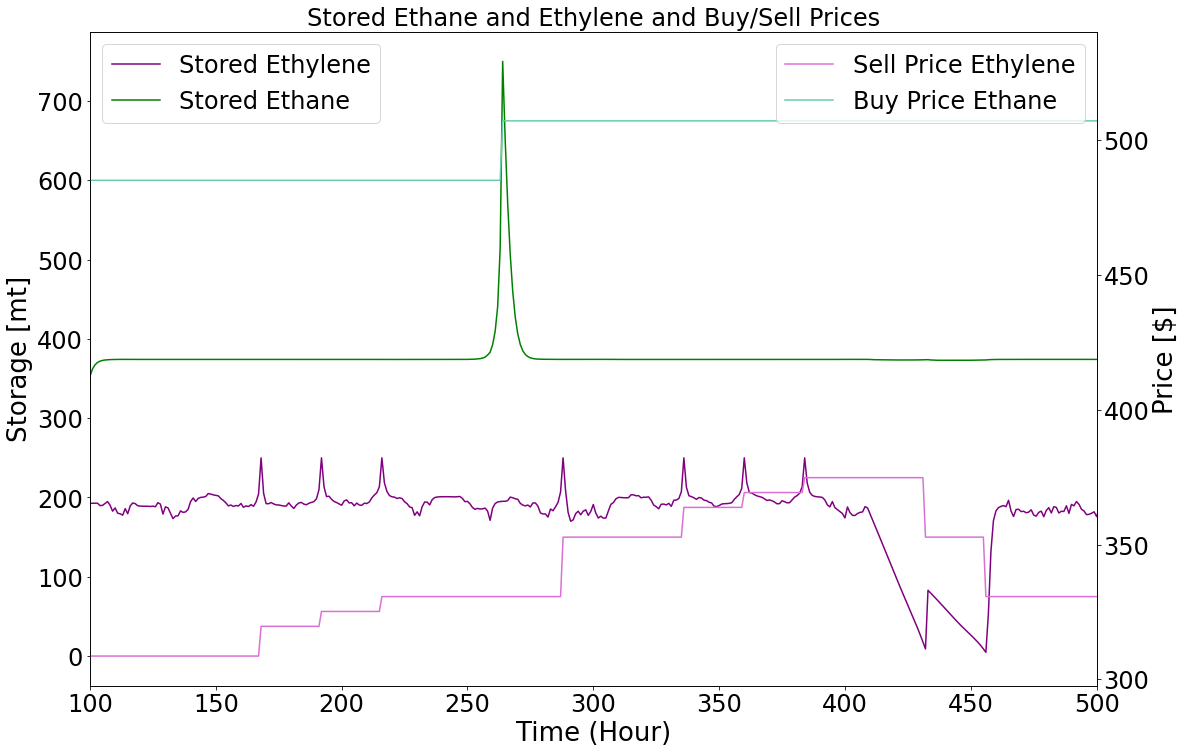

In [17]:
fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene")
ax.plot(St_f_j, color="green", label="Stored Ethane")
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
ax.set_xlim([100, 500])
plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
plt.tight_layout()
plt.show()

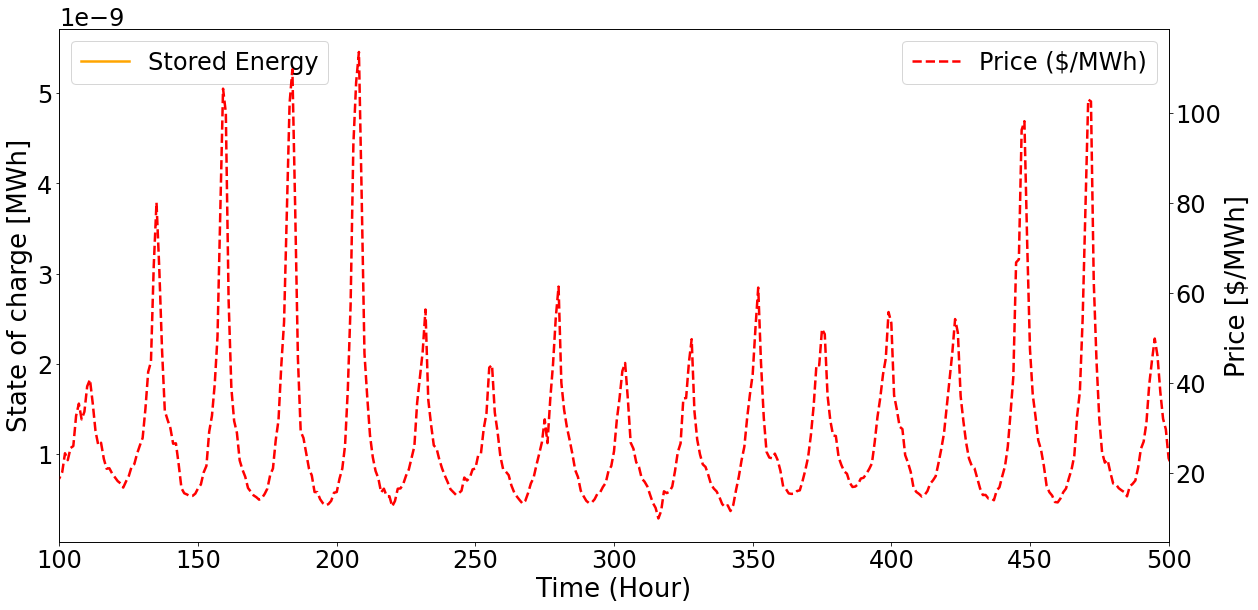

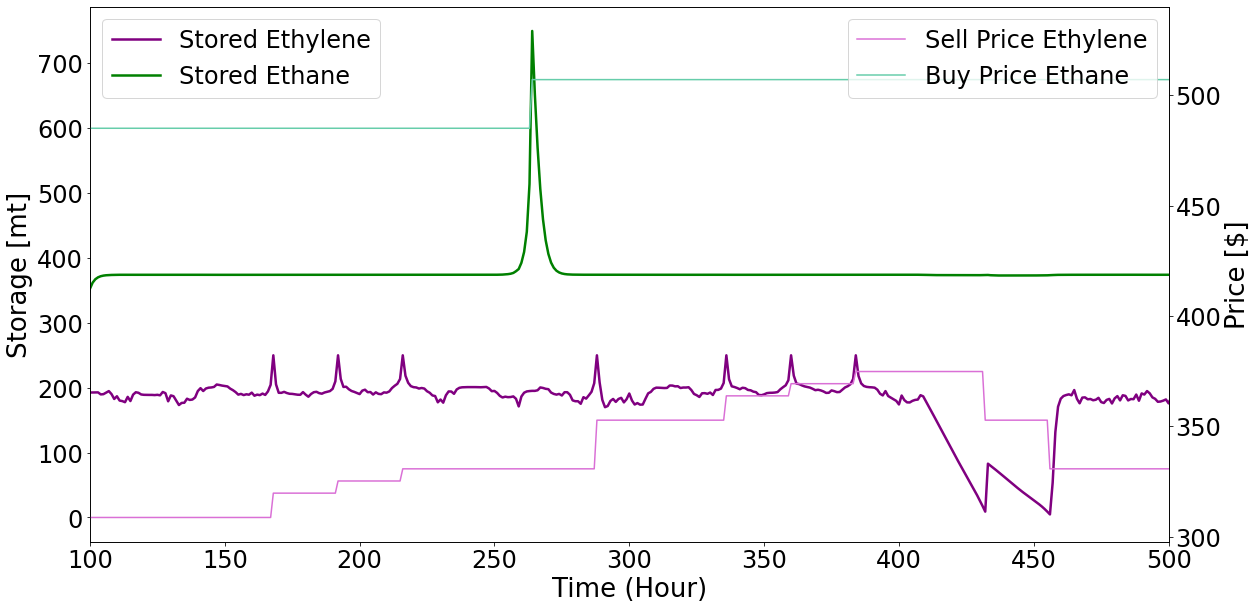

In [18]:
# battery state of charge and electricity price - 
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('State of charge [MWh]')
ax2.set_ylabel('Price [$/MWh]')
ax.plot(E_b.value, color="orange", label="Stored Energy", linewidth=2.5)
ax2.plot(C_gr, color="red", label="Electricity Price", linestyle='dashed', linewidth=2.5, )
ax.legend(['Stored Energy', 'Electricity Price'], loc='upper left')
ax2.legend(['Price ($/MWh)'], loc='upper right')
plt.tight_layout()
#plt.title("Battery state of charge and wholesale electricity prices")
ax.set_xlim([100, 500])
#ax.set_ylim([-5, max(E_b.value)+10])
plt.show()
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene", linewidth=2.5)
ax.plot(St_f_j, color="green", label="Stored Ethane", linewidth=2.5)
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
plt.tight_layout()
#plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
ax.set_xlim([100, 500])
plt.show()

## December

In [19]:
start = timeit.default_timer()
 
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min # [MW/hr]
eff = 0.95 # battery efficiency
t = 720 # one month duration # [hours]
month = "december" # or "june"
cost = "wholesale" # "fixed" 
c_fix = 19.75 # june 19.75, december 21.19 # [$/MWh]
storage_limit_e = 250 # [mt]
storage_limit_h = 250 # [mt]
storage_limit_f = 750  # [mt]
outage = "no" # or "yes"
op_c = 85.75 # operational cost # [$]
pc_multiplier = 1
# outage_duration = 4 # [hours] # if outage = yes
# outage_start = 100 # [hour] # if outage = yes
battery_duration = 4 # 1 hour battery, 4 hour battery, etc

E_max_stor = []
prob_stor = []
C_b_stor = []
S_max_stor = []
P_c_stor = []
S_l_e_stor = []
S_l_h_stor = []
Pd_e_stor = []
C_g_stor = []
C_s_stor = []
St_e_stor = []
St_f_stor = []
E_b_i = 0
St_e_i = 0
St_h_i = 0
St_f_i = 0

P_L = [] # loads # MW
P_L = Loads(P_L, t)
P_s = [] # power generated by solar # MW
P_s = Solar(P_s, month, t)
S_p_e = [] # sell price # [$/mt]
S_p_e = SellPrice_e(month, S_p_e) 
S_p_h = [] # sell price # [$/mt]
S_p_h = SellPrice_h(month, S_p_h)
B_p = [] # buy price # [$/mt]
B_p = BuyPrice(month, B_p)
C_gr = [] # cost of power from the grid #[$/mt]
C_gr = GridCost(C_gr, month, t, cost, c_fix)

# plt.plot(P_L, label="P_L")
# plt.plot(P_s, label="P_s")
# plt.plot(S_p_e, label="se")
# plt.plot(S_p_h, label="sh")
# plt.plot(B_p, label="bp")
# plt.plot(C_gr, label="cg")
# plt.legend()
# plt.show()

assert 0 < eff <= 1.0, "efficiency must be between (0,1]"

for m in range(t-24): 
    sta = timeit.default_timer()
    
    E_max = cp.Variable() # establishing battery capacity (MW)
    E_b = cp.Variable(N+1) # defining battery charge variable
    P_g = cp.Variable(N) # power drawn from the grid
    P_ch = cp.Variable(N) # battery charge
    P_dis = cp.Variable(N) # battery discharge []
    S_max = cp.Variable() # size of the solar panels 
    St_e = cp.Variable(N+1) # ethylene storage [mt]
    Sl_e = cp.Variable(N) # sold ethylene [mt]
    St_h = cp.Variable(N+1) # hydrogen storage [mt]
    Sl_h = cp.Variable(N) # sold hydrogen [mt]
    St_f = cp.Variable(N+1) # feedstock storage [mt]
    Bt_f = cp.Variable(N+1) # bought feedstock [mt]
    Pd_e = cp.Variable(N) # production of ethylene [mt]
    Pd_h = cp.Variable(N) # production of hydrogen [mt]
    Pd_f = cp.Variable(N) # production of feedstock [mt]

    C_s = S_max*Cost(1000000*0.89*20) # [$]
    C_b = E_max*(Cost(87000)) # [$]
    C_g = []
    for n in range(N):
        C_g += [(C_gr[m+n])*P_g[n]]  
    
    constraints = []   
    constraints += [P_g >= 0] # power draw is not negative # [MW >= MW]
    constraints += [P_L[m:N+m] == P_g + P_dis + -P_ch + P_s[m:N+m]*S_max] # the sources sum to load requirements # [MW = MW + MW + MW + MW]
    constraints += [E_b[0] == E_b_i] # battery charge at start is zero # [MW = MW]
    constraints += [P_ch >= 0] # charge into the is not negative # [MW >= MW]
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    constraints += [S_max >= 0] # can't have negative solar capacity 
    constraints += [S_max <= 1] # solar 20000 kW or less
    constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
    for n in range (0, N-1):     # ramp value constraints - power change between time steps can't exceed ramp limit
        constraints += [(P_g[n] - P_g[n+1]) <= P_ramp] # [MW - MW <= MW]
        constraints += [(P_g[n] - P_g[n+1]) >= -P_ramp]  # [MW - MW >= MW]
    constraints += [St_e[0] == St_e_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_h[0] == St_h_i] # storage at time 0 = 0 # [mt = mt]
    constraints += [St_f[0] == St_f_i] # storage empty at start # [mt = mt]
    
    for n in range (0, N):
        constraints += [E_max/battery_duration >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity #[MW=MW]
        constraints += [E_max/battery_duration >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy #[MW=MW]
        constraints += [St_e[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_h[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit # [mt = mt]
        constraints += [St_f[n] >= 0] # storage between 0 and limit # [mt = mt]
        constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit # [mt = mt]
        constraints += [Sl_e[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Sl_e <= St_e[n]+Pd_e[n]] # sold ethylene less than produced # [mt = mt]
        constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Sl_h[n] >= 0] # selling ethylene not buying # [mt = mt]
        constraints += [Pd_h[n] == Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    #     constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
        constraints += [Bt_f[n] >= 0] # buying not selling # [mt = mt]
        constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep # [mt = mt]
    
    if N == 1: # no MPC - no way to use storage
        constraints += [St_h == 0, E_b == 0, St_e == 0, St_f == 0]
        constraints += [Bt_f == Pd_f]
        constraints += [Pd_h == Sl_h]
        constraints += [Pd_e == Sl_e]
    else:
        for n in range (1, N+1):
            constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery # [Mw = MW + MW - MW]
            constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            # currently no hydrogen storage
            constraints += [St_h[n] == 0] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
            constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used # [mt = mt + mt - mt]
    
    for n in range (0, N+1):
        constraints += [E_b[n] >= 0] # battery charge is not negative # [MW >= MW]
        constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity  # [MW >= MW]
    
    if (outage=="yes"):
        for n in range (outage_start, outage_start + outage_duration):
            constraints += [P_g[n] == 0] # [MW = MW]   
            constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt >= 1/MW*mt*MW]
            constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt <= 1/MW*mt*MW]
        for n in range(0, outage_start):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
        for n in range(outage_start + outage_duration, t):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    elif (outage=="no"):
        for n in range(0, N):
            constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    
    for n in range(0, N):
        constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05] # hydrogen mol/ethylene mol conversion # [mt = mt * mol/mol]
        constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05] # ethane mol/ethylene mol conversion # [mt = mt * mol/mol]
    P_c = [] # bought ethylene including price # [$ = $/mt * mt]
    S_l_e = [] # sold ethylene including price # [$ = $/mt * mt]
    S_l_h = [] # sold ethylene including price # [$ = $/mt * mt]
    for n in range(N):
        P_c += [Bt_f[n] * B_p[n+m]]
        S_l_e += [Sl_e[n] * S_p_e[n+m]]
        S_l_h += [Sl_h[n] * S_p_h[n+m]]
        
    sumpde = []
    for n in range((Pd_e).size):
        sumpde += [Pd_e[n]]

    objective = op_c*sum(sumpde) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
#     objective = op_c*sum(Pd_e) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve() 
#     print(prob.status)
    
    E_max_stor += [E_max.value]
    prob_stor += [prob.value]
    C_b_stor += [C_b.value]
    S_max_stor += [S_max.value]
    P_c_stor += [P_c[0].value]
    S_l_e_stor += [S_l_e[0].value]
    S_l_h_stor += [S_l_h[0].value]
    E_b_i = E_b[1].value
    St_e_i = St_e[1].value
    St_h_i = St_h[1].value
    St_f_i = St_f[1].value
    Pd_e_stor += [Pd_e[0].value]
    C_g_stor += [C_g[0].value]
    C_s_stor += [C_s.value]
    St_e_stor += [St_e[0].value]
    St_f_stor += [St_f[0].value]
    
    sto = timeit.default_timer()
#     print("Time (seconds):", sto-sta)
    
#     print("a:", E_max.value, "b:", E_b.value, "c:", P_g.value, "d:", P_ch.value, "e:", P_dis.value, "f:", S_max.value,  "g:", St_e.value, "h:", Sl_e.value, "i:", St_h.value, "j:", Sl_h.value, "k:", St_f.value, "l:", Bt_f.value, "m:", Pd_e.value, "n:", Pd_h.value, "o:", Pd_f.value)
    

#printing results
obj_tot = op_c*sum(Pd_e_stor) + sum(C_g_stor) + max(C_b_stor) + max(S_max_stor)*Cost(1000000*0.89*20) + sum(P_c_stor)*pc_multiplier - sum(S_l_e_stor) - sum(S_l_h_stor) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
print("Battery Capacity [MW]: ", max(E_max_stor))
print("Cost of Battery [$]: ", max(C_b_stor))
print("Solar Size [MW]: ", max(S_max_stor)*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c_stor))
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e_stor))
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h_stor))
print("Overall Profit", -obj_tot)
if 0 > obj_tot:
    print("Profit")
else:
    print("Loss")

stop = timeit.default_timer()

print('Time (seconds): ', stop - start) 

Battery Capacity [MW]:  1.6718731964139226e-06
Cost of Battery [$]:  0.0008784880813908595
Solar Size [MW]:  3.023156407613057e-09
Cost of Bought Ethane [tons]:  40091000.83142915
Cost of Sold Ethylene [tons]:  34744885.60263292
Cost of Sold Hydrogen [tons]:  20214162.48185513
Overall Profit 1426581.5316611677
Profit
Time (seconds):  459.7705393


In [20]:
S_l_e_d = S_l_e_stor
S_l_h_d = S_l_h_stor
P_c_d = P_c_stor
C_s_d = C_s_stor
C_b_d = C_b_stor
C_g_d = C_g_stor
Pd_e_d = Pd_e_stor
St_e_d = St_e_stor
St_f_d = St_f_stor

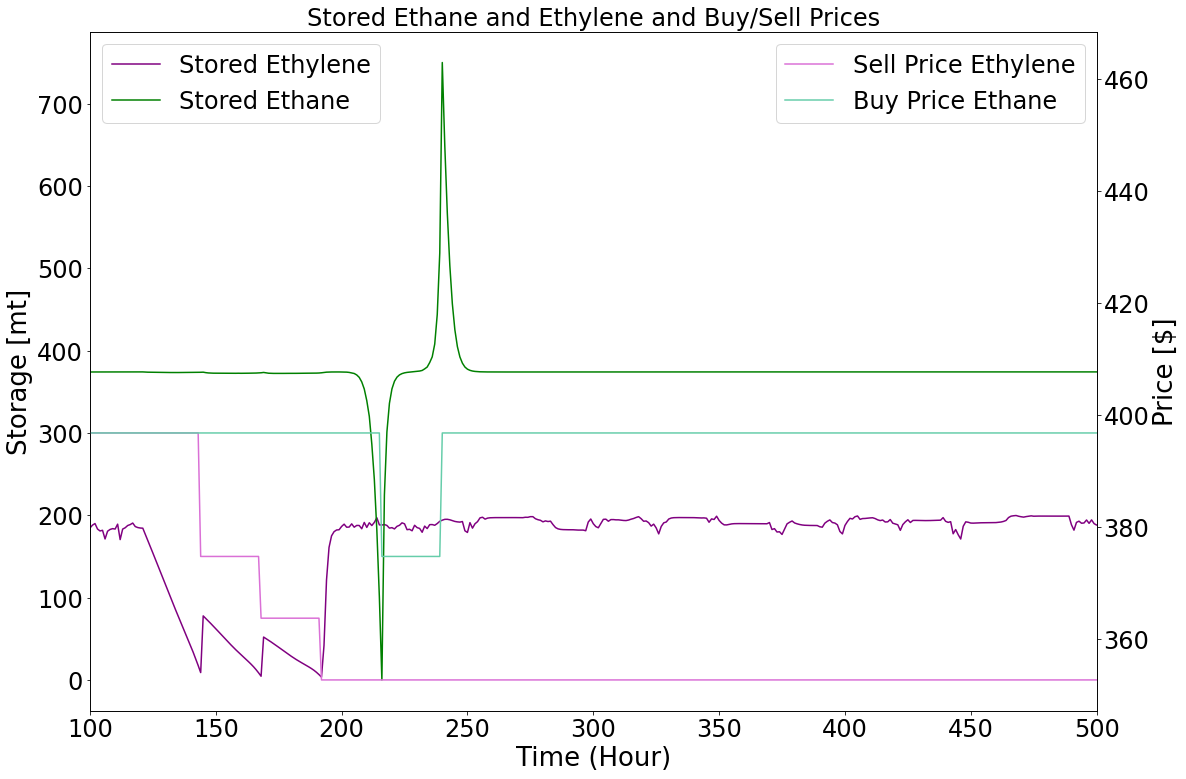

In [21]:
fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_d, color="purple", label="Stored Ethylene")
ax.plot(St_f_d, color="green", label="Stored Ethane")
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
ax.set_xlim([100, 500])
plt.tight_layout()
plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
plt.show()

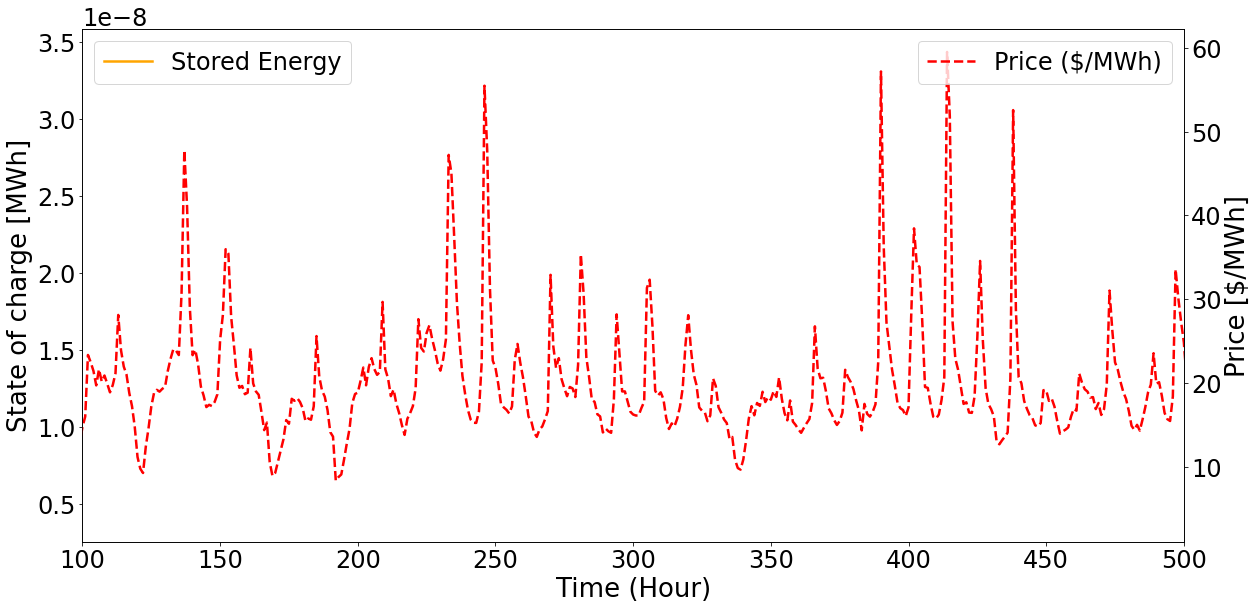

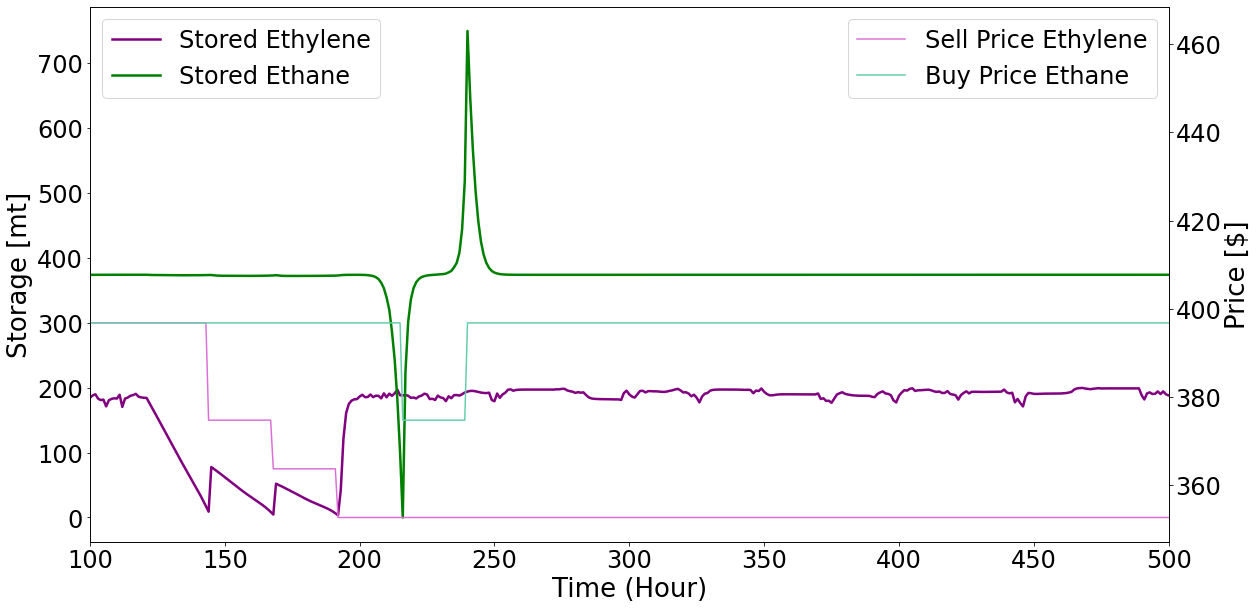

In [22]:
# battery state of charge and electricity price - 
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('State of charge [MWh]')
ax2.set_ylabel('Price [$/MWh]')
ax.plot(E_b.value, color="orange", label="Stored Energy", linewidth=2.5)
ax2.plot(C_gr, color="red", label="Electricity Price", linestyle='dashed', linewidth=2.5, )
ax.legend(['Stored Energy', 'Electricity Price'], loc='upper left')
ax2.legend(['Price ($/MWh)'], loc='upper right')
plt.tight_layout()
#plt.title("Battery state of charge and wholesale electricity prices")
ax.set_xlim([100, 500])
#ax.set_ylim([-5, max(E_b.value)+10])
plt.show()
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_d, color="purple", label="Stored Ethylene", linewidth=2.5)
ax.plot(St_f_d, color="green", label="Stored Ethane", linewidth=2.5)
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
plt.tight_layout()
#plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
ax.set_xlim([100, 500])
plt.show()

# Plotting

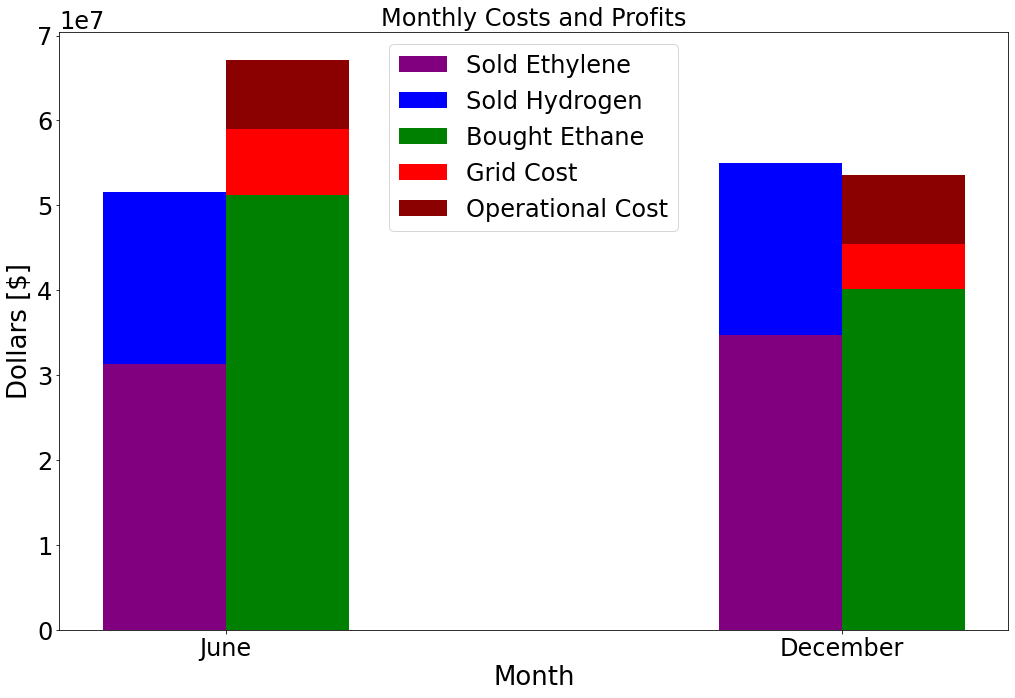

In [23]:
from pylab import *
fig, ax = plt.subplots(figsize=(17,11))
width = 0.5

ax.bar(0, sum(S_l_e_j), width, color="purple", align='edge', label="Sold Ethylene")
ax.bar(0, sum(S_l_h_j), width, color="blue", align='edge', bottom=sum(S_l_e_j), label="Sold Hydrogen")
ax.bar(0.5, sum(P_c_j)*pc_multiplier, width, color="green", align='edge', label="Bought Ethane")
# ax.bar(0.5, max(C_s_j), width, color="gold", align='edge', bottom=sum(P_c_j)*pc_multiplier, label="solar cost june")
# ax.bar(0.5, max(C_b_j), width, color="orange", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j, label="battery cost june")
ax.bar(0.5, sum(C_g_j), width, color="red", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j, label="Grid Cost")
ax.bar(0.5, op_c*sum(Pd_e_j), width, color="darkred", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j+sum(C_g_j), label="Operational Cost")

ax.bar(2.5, sum(S_l_e_d), width, color="purple", align='edge')
ax.bar(2.5, sum(S_l_h_d), width, color="blue", align='edge', bottom=sum(S_l_e_d))
ax.bar(3, sum(P_c_d)*pc_multiplier, width, color="green", align='edge')
# ax.bar(2.5, max(C_s_d), width, color="gold", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier, label="solar cost december")
# ax.bar(2.5, max(C_b_d), width, color="orange", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d, label="battery cost december")
ax.bar(3, sum(C_g_d), width, color="red", align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d)
ax.bar(3, op_c*sum(Pd_e_d), width, color="darkred", align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d+sum(C_g_d))

ax.set_ylabel('Dollars [$]')
ax.set_xlabel('Month')

x1 = [0.5,3]
labels = ['June', 'December']
ax.set_xticks(x1)
ax.set_xticklabels(labels, minor=False)

ax.set_title('Monthly Costs and Profits')
ax.legend(loc="upper center")
plt.show()

## Generalized: June

In [24]:
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min # [MW/hr]
eff = 0.95 # battery efficiency
t = 720-24 # one month duration # [hours]
month = "june" # or "december"
cost = "wholesale" # or "fixed"
c_fix = 19.75 # june 19.75, december 21.19 # [$/MWh]
storage_limit_e = 250 # [mt]
storage_limit_h = 250 # [mt]
storage_limit_f = 750  # [mt]
outage = "no" # or "yes"
op_c = 85.75 # operational cost # [$]
pc_multiplier = 1
# outage_duration = 4 # [hours] # if outage = yes
# outage_start = 100 # [hour] # if outage = yes
battery_duration = 4 # 1 hour battery, 4 hour battery, etc

E_max = cp.Variable() # establishing battery capacity (MW)
E_b = cp.Variable(t+1) # defining battery charge variable
P_g = cp.Variable(t) # power drawn from the grid
P_ch = cp.Variable(t) # battery charge
P_dis = cp.Variable(t) # battery discharge []
S_max = cp.Variable() # size of the solar panels 
St_e = cp.Variable(t+1) # ethylene storage [mt]
Sl_e = cp.Variable(t) # sold ethylene [mt]
St_h = cp.Variable(t+1) # hydrogen storage [mt]
Sl_h = cp.Variable(t) # sold hydrogen [mt]
St_f = cp.Variable(t+1) # feedstock storage [mt]
Bt_f = cp.Variable(t+1) # bought feedstock [mt]
Pd_e = cp.Variable(t) # production of ethylene [mt]
Pd_h = cp.Variable(t) # production of hydrogen [mt]
Pd_f = cp.Variable(t) # production of feedstock [mt]

C_s = S_max*Cost(1000000*0.89*20) # [$]
C_b = E_max*(Cost(87000)) # [$]
P_L = [] # loads # MW
P_L = Loads(P_L, t)
P_s = [] # power generated by solar # MW
P_s = Solar(P_s, month, t)
C_gr = [] # cost of power from the grid #[$/mt]
C_gr = GridCost(C_gr, month, t, cost, c_fix)
C_g = []
for n in range(t):
    C_g += [(C_gr[n])*P_g[n]]  
S_p_e = [] # sell price # [$/mt]
S_p_e = SellPrice_e(month, S_p_e) 
S_p_h = [] # sell price # [$/mt]
S_p_h = SellPrice_h(month, S_p_h)
B_p = [] # buy price # [$/mt]
B_p = BuyPrice(month, B_p)

constraints = []
constraints += [P_g >= 0] # power draw is not negative # [MW >= MW]
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements # [MW = MW + MW + MW + MW]
constraints += [E_b[0] == 0] # battery charge at start is zero # [MW = MW]
constraints += [P_ch >= 0] # charge into the is not negative # [MW >= MW]
constraints += [1 >= eff] #efficiency cannot be greater than one 
constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
constraints += [S_max >= 0] # can't have negative solar capacity 
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    constraints += [(P_g[n] - P_g[n+1]) <= P_ramp] # [MW - MW <= MW]
    constraints += [(P_g[n] - P_g[n+1]) >= -P_ramp]  # [MW - MW >= MW]
constraints += [St_e[0] == 0] # storage at time 0 = 0 # [mt = mt]
constraints += [St_h[0] == 0] # storage at time 0 = 0 # [mt = mt]
constraints += [St_f[0] == 0] # storage empty at start # [mt = mt]
for n in range (0, t):
    constraints += [E_max/battery_duration >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity #[MW=MW]
    constraints += [E_max/battery_duration >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy #[MW=MW]
    constraints += [St_e[n] >= 0] # storage between 0 and limit # [mt = mt]
    constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit # [mt = mt]
    constraints += [St_h[n] >= 0] # storage between 0 and limit # [mt = mt]
    constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit # [mt = mt]
    constraints += [St_f[n] >= 0] # storage between 0 and limit # [mt = mt]
    constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit # [mt = mt]
    constraints += [Sl_e[n] >= 0] # selling ethylene not buying # [mt = mt]
    constraints += [Sl_e[0] == 0] # can't sell in at hour 0 # [mt = mt]
    constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    constraints += [Sl_h[n] >= 0] # selling ethylene not buying # [mt = mt]
#     constraints += [Sl_h[0] == 0] # can't sell in at hour 0 # [mt = mt]
    constraints += [Pd_h[n] == Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
#     constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    constraints += [Bt_f[n] >= 0] # buying not selling # [mt = mt]
#     constraints += [Bt_f[0] == 0] # can't buy in at hour 0 # [mt = mt]
    constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep # [mt = mt]
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery # [Mw = MW + MW - MW]
    constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
    constraints += [St_h[n] == 0] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
#     constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
    constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used # [mt = mt + mt - mt]
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative # [MW >= MW]
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity  # [MW >= MW]
if (outage=="yes"):
    for n in range (outage_start, outage_start + outage_duration):
        constraints += [P_g[n] == 0] # [MW = MW]   
        constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt >= 1/MW*mt*MW]
        constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt <= 1/MW*mt*MW]
    for n in range(0, outage_start):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    for n in range(outage_start + outage_duration, t):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
elif (outage=="no"):
    for n in range(0, t):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
for n in range(0, t):
    constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05] # hydrogen mol/ethylene mol conversion # [mt = mt * mol/mol]
    constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05] # ethane mol/ethylene mol conversion # [mt = mt * mol/mol]
P_c = [] # bought ethylene including price # [$ = $/mt * mt]
S_l_e = [] # sold ethylene including price # [$ = $/mt * mt]
S_l_h = [] # sold ethylene including price # [$ = $/mt * mt]
for n in range(t):
    P_c += [Bt_f[n] * B_p[n]]
    S_l_e += [Sl_e[n] * S_p_e[n]]
    S_l_h += [Sl_h[n] * S_p_h[n]]
    
sumpde = []
for n in range((Pd_e).size):
    sumpde += [Pd_e[n]]

objective = op_c*sum(sumpde) + sum(C_g) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
# objective = op_c*sum(Pd_e) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]

prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $ (neg is profit)", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [MW]: ", S_max.value*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c).value)
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e).value)
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h).value)

S_l_e_j = []
S_l_h_j = [] 
P_c_j = []
C_g_j = []
Pd_e_j = []
St_e_j = []
St_f_j = []
for n in range(len(S_l_e)):
    S_l_e_j += [S_l_e[n].value]
    S_l_h_j += [S_l_h[n].value]
    P_c_j += [P_c[n].value]
    C_g_j += [C_g[n].value]
    Pd_e_j += [Pd_e[n].value]
    St_e_j += [St_e[n].value]
    St_f_j += [St_f[n].value]
C_s_j = C_s.value
C_b_j = C_b.value

status: optimal
Battery Capacity [MW]:  2173.6842105534283
Minimized Cost: $ (neg is profit) 14237848.444719821
Cost of Battery [$]:  1142165.3722151774
Solar Size [MW]:  -2.117458314620179e-09
Cost of Bought Ethane [tons]:  50927968.39717613
Cost of Sold Ethylene [tons]:  31457556.458015457
Cost of Sold Hydrogen [tons]:  20214162.481279008


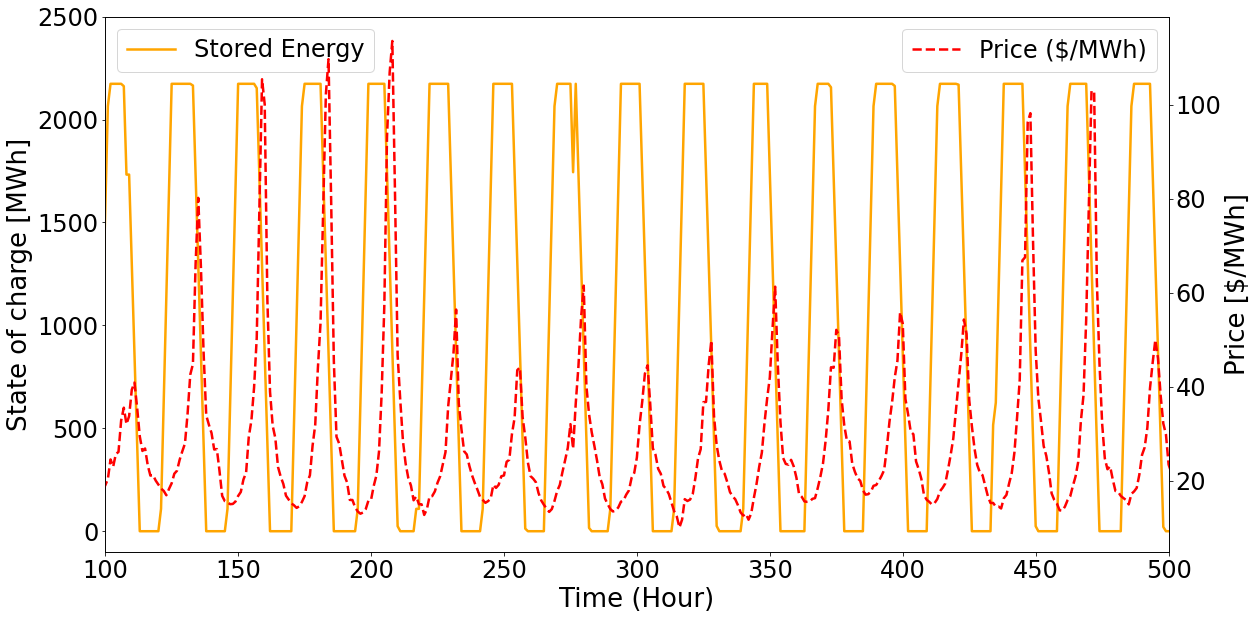

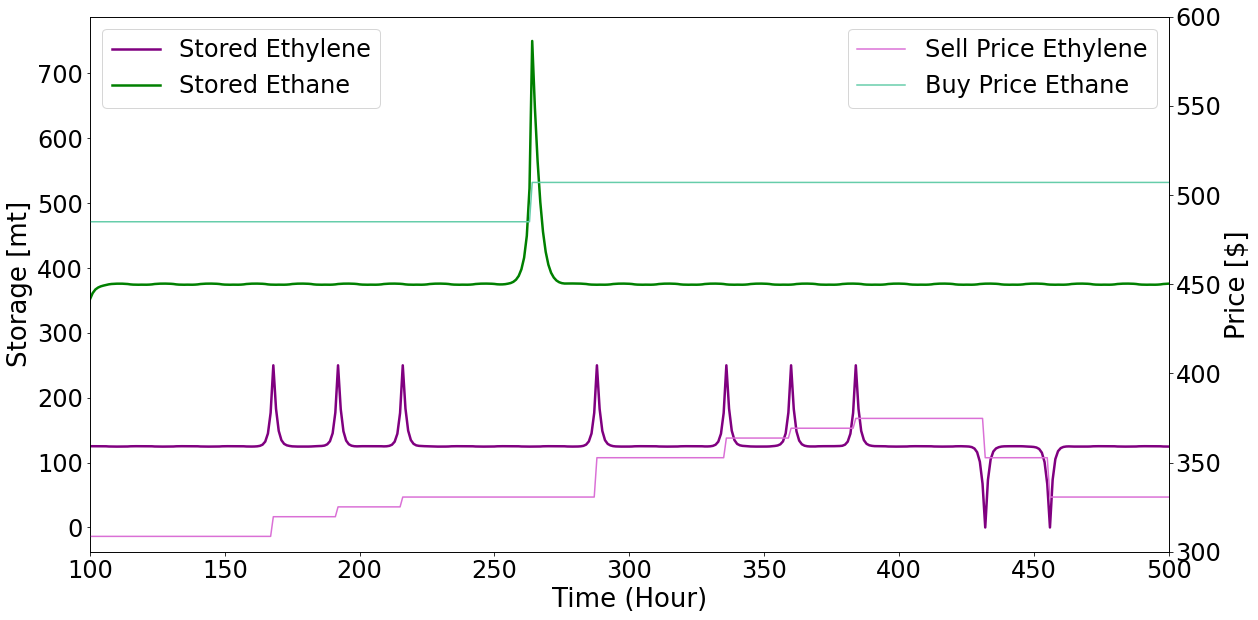

In [25]:
# battery state of charge and electricity price - 
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('State of charge [MWh]')
ax2.set_ylabel('Price [$/MWh]')
ax.plot(E_b.value, color="orange", label="Stored Energy", linewidth=2.5)
ax2.plot(C_gr, color="red", label="Electricity Price", linestyle='dashed', linewidth=2.5, )
ax.legend(['Stored Energy', 'Electricity Price'], loc='upper left')
ax2.legend(['Price ($/MWh)'], loc='upper right')
plt.tight_layout()
#plt.title("Battery state of charge and wholesale electricity prices")
ax.set_xlim([100, 500])
ax.set_ylim([-100, 2500])
#ax.set_ylim([-5, max(E_b.value)+10])
plt.show()
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene", linewidth=2.5)
ax.plot(St_f_j, color="green", label="Stored Ethane", linewidth=2.5)
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
plt.tight_layout()
#plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
ax.set_xlim([100, 500])
ax2.set_ylim([300, 600])

plt.show()

## Generalized: December

In [26]:
P_ramp = 20*60 # ramp values # ~20 MW/min for gas, coal would be ~2 MW/min
eff = 0.95 # battery efficiency
t = 720-24 # one month duration (hours)
month = "december" # or "june"
cost = "wholesale" # or "fixed"
c_fix = 19.75 # june 19.75, december 21.19 # [$/MWh]
storage_limit_e = 250 # [mt]
storage_limit_h = 250 # [mt]
storage_limit_f = 750  # [mt]
outage = "no" # or "yes"
op_c = 85.75 # operational cost # [$]
pc_multiplier = 1
# outage_duration = 4 # [hours] # if outage = yes
# outage_start = 100 # [hour] # if outage = yes
battery_duration = 4 # 1 hour battery, 4 hour battery, etc

E_max = cp.Variable() # establishing battery capacity (MW)
E_b = cp.Variable(t+1) # defining battery charge variable
P_g = cp.Variable(t) # power drawn from the grid
P_ch = cp.Variable(t) # battery charge
P_dis = cp.Variable(t) # battery discharge []
S_max = cp.Variable() # size of the solar panels 
St_e = cp.Variable(t+1) # ethylene storage [mt]
Sl_e = cp.Variable(t) # sold ethylene [mt]
St_h = cp.Variable(t+1) # hydrogen storage [mt]
Sl_h = cp.Variable(t) # sold hydrogen [mt]
St_f = cp.Variable(t+1) # feedstock storage [mt]
Bt_f = cp.Variable(t+1) # bought feedstock [mt]
Pd_e = cp.Variable(t) # production of ethylene [mt]
Pd_h = cp.Variable(t) # production of hydrogen [mt]
Pd_f = cp.Variable(t) # production of feedstock [mt]

C_s = S_max*Cost(1000000*0.89*20) # [$]
C_b = E_max*(Cost(87000)) # [$]
P_L = [] # loads # MW
P_L = Loads(P_L, t)
P_s = [] # power generated by solar # MW
P_s = Solar(P_s, month, t)
C_gr = [] # cost of power from the grid #[$/mt]
C_gr = GridCost(C_gr, month, t, cost, c_fix)
C_g = []
for n in range(t):
    C_g += [(C_gr[n])*P_g[n]]  
S_p_e = [] # sell price # [$/mt]
S_p_e = SellPrice_e(month, S_p_e) 
S_p_h = [] # sell price # [$/mt]
S_p_h = SellPrice_h(month, S_p_h)
B_p = [] # buy price # [$/mt]
B_p = BuyPrice(month, B_p)

constraints = []
constraints += [P_g >= 0] # power draw is not negative # [MW >= MW]
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements # [MW = MW + MW + MW + MW]
constraints += [E_b[0] == 0] # battery charge at start is zero # [MW = MW]
constraints += [P_ch >= 0] # charge into the is not negative # [MW >= MW]
constraints += [1 >= eff] #efficiency cannot be greater than one 
constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
constraints += [S_max >= 0] # can't have negative solar capacity 
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative # [MW >= MW]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    constraints += [(P_g[n] - P_g[n+1]) <= P_ramp] # [MW - MW <= MW]
    constraints += [(P_g[n] - P_g[n+1]) >= -P_ramp]  # [MW - MW >= MW]
constraints += [St_e[0] == 0] # storage at time 0 = 0 # [mt = mt]
constraints += [St_h[0] == 0] # storage at time 0 = 0 # [mt = mt]
constraints += [St_f[0] == 0] # storage empty at start # [mt = mt]
for n in range (0, t):
    constraints += [E_max/battery_duration >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity #[MW=MW]
    constraints += [E_max/battery_duration >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy #[MW=MW]
    constraints += [St_e[n] >= 0] # storage between 0 and limit # [mt = mt]
    constraints += [storage_limit_e >= St_e[n]] # storage between 0 and limit # [mt = mt]
    constraints += [St_h[n] >= 0] # storage between 0 and limit # [mt = mt]
    constraints += [storage_limit_h >= St_h[n]] # storage between 0 and limit # [mt = mt]
    constraints += [St_f[n] >= 0] # storage between 0 and limit # [mt = mt]
    constraints += [storage_limit_f >= St_f[n]] # storage between 0 and limit # [mt = mt]
    constraints += [Sl_e[n] >= 0] # selling ethylene not buying # [mt = mt]
    constraints += [Sl_e[0] == 0] # can't sell in at hour 0 # [mt = mt]
    constraints += [storage_limit_e >= Sl_e[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    constraints += [Sl_h[n] >= 0] # selling ethylene not buying # [mt = mt]
#     constraints += [Sl_h[0] == 0] # can't sell in at hour 0 # [mt = mt]
    constraints += [Pd_h[n] == Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
#     constraints += [storage_limit_h >= Sl_h[n]] # can't sell more than storage limit in a given timestep # [mt = mt]
    constraints += [Bt_f[n] >= 0] # buying not selling # [mt = mt]
#     constraints += [Bt_f[0] == 0] # can't buy in at hour 0 # [mt = mt]
    constraints += [storage_limit_f >= Bt_f[n]] # can't buy more than storage limit in a given timestep # [mt = mt]
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] # battery effectiveness impacts charge/discharge amounts of battery # [Mw = MW + MW - MW]
    constraints += [St_e[n] == St_e[n-1] + Pd_e[n-1] - Sl_e[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
    constraints += [St_h[n] == 0] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
#     constraints += [St_h[n] == St_h[n-1] + Pd_h[n-1] - Sl_h[n-1]] # storage at next time = current + produced - sold # [mt = mt + mt - mt]
    constraints += [St_f[n] == St_f[n-1] + Bt_f[n-1] - Pd_f[n-1]] # storage at next time = current + bought - used # [mt = mt + mt - mt]
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative # [MW >= MW]
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity  # [MW >= MW]
if (outage=="yes"):
    for n in range (outage_start, outage_start + outage_duration):
        constraints += [P_g[n] == 0] # [MW = MW]   
        constraints += [Pd_e[n] >= 0.9*(len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt >= 1/MW*mt*MW]
        constraints += [Pd_e[n] <= (len(P_L)/sum(P_L))*134.7*P_L[n]] # [mt <= 1/MW*mt*MW]
    for n in range(0, outage_start):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
    for n in range(outage_start + outage_duration, t):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
elif (outage=="no"):
    for n in range(0, t):
        constraints += [Pd_e[n] == (len(P_L)/sum(P_L))*134.7*P_L[n]]  # [mt == 1/MW*mt*MW]
for n in range(0, t):
    constraints += [Pd_h[n] == Pd_e[n] * 2.016/28.05] # hydrogen mol/ethylene mol conversion # [mt = mt * mol/mol]
    constraints += [Pd_f[n] == Pd_e[n] * 30.07/28.05] # ethane mol/ethylene mol conversion # [mt = mt * mol/mol]
P_c = [] # bought ethylene including price # [$ = $/mt * mt]
S_l_e = [] # sold ethylene including price # [$ = $/mt * mt]
S_l_h = [] # sold ethylene including price # [$ = $/mt * mt]
for n in range(t):
    P_c += [Bt_f[n] * B_p[n]]
    S_l_e += [Sl_e[n] * S_p_e[n]]
    S_l_h += [Sl_h[n] * S_p_h[n]]
sumpde = []
for n in range((Pd_e).size):
    sumpde += [Pd_e[n]]

objective = op_c*sum(sumpde) + sum(C_g) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
# objective = op_c*sum(Pd_e) + sum(C_g[m:N+m]) + C_b + C_s + sum(P_c)*pc_multiplier - sum(S_l_e) - sum(S_l_h) # [$ = $/mt * mt + $ + $ + $ + $ - $ - $]
 
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $ (neg is profit)", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [MW]: ", S_max.value*20)
print("Cost of Bought Ethane [tons]: ", sum(P_c).value)
print("Cost of Sold Ethylene [tons]: ", sum(S_l_e).value)
print("Cost of Sold Hydrogen [tons]: ", sum(S_l_h).value)

S_l_e_d = []
S_l_h_d = [] 
P_c_d = []
C_g_d = []
Pd_e_d = []
St_e_d = []
St_f_d = []
for n in range(len(S_l_e)):
    S_l_e_d += [S_l_e[n].value]
    S_l_h_d += [S_l_h[n].value]
    P_c_d += [P_c[n].value]
    C_g_d += [C_g[n].value]
    Pd_e_d += [Pd_e[n].value]
    St_e_d += [St_e[n].value]
    St_f_d += [St_f[n].value]
C_s_d = C_s.value
C_b_d = C_b.value

status: optimal
Battery Capacity [MW]:  2.0448299946178448e-05
Minimized Cost: $ (neg is profit) -1743766.3731181584
Cost of Battery [$]:  0.010744587463902193
Solar Size [MW]:  -1.2429717094888244e-08
Cost of Bought Ethane [tons]:  39885030.63181484
Cost of Sold Ethylene [tons]:  34856100.24565817
Cost of Sold Hydrogen [tons]:  20214162.48166581


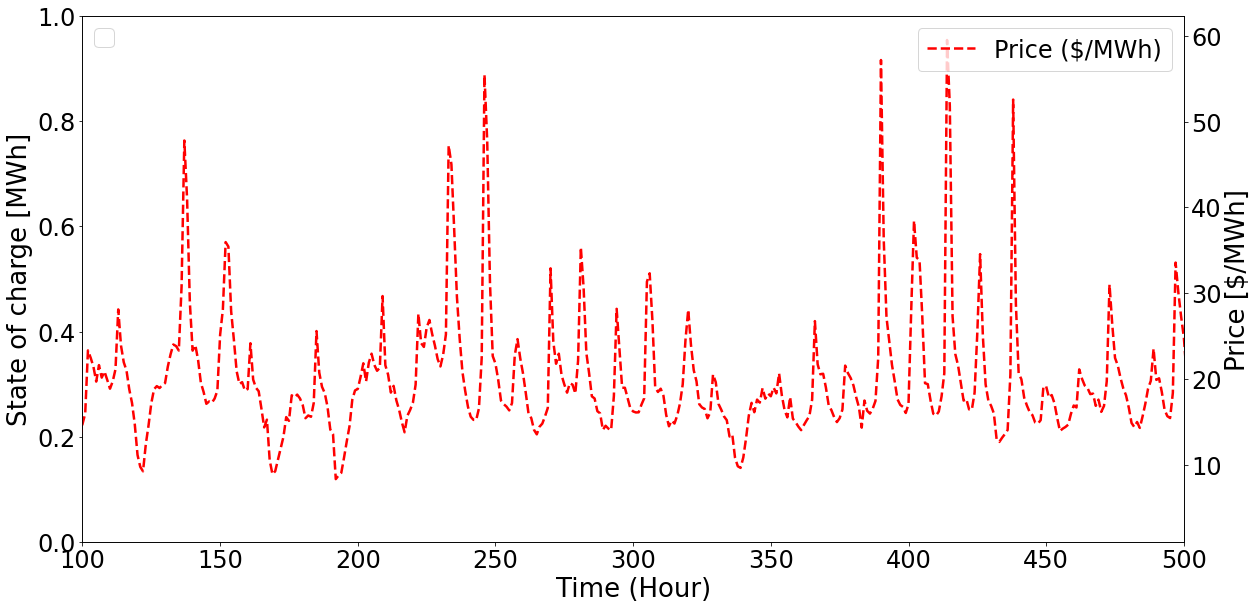

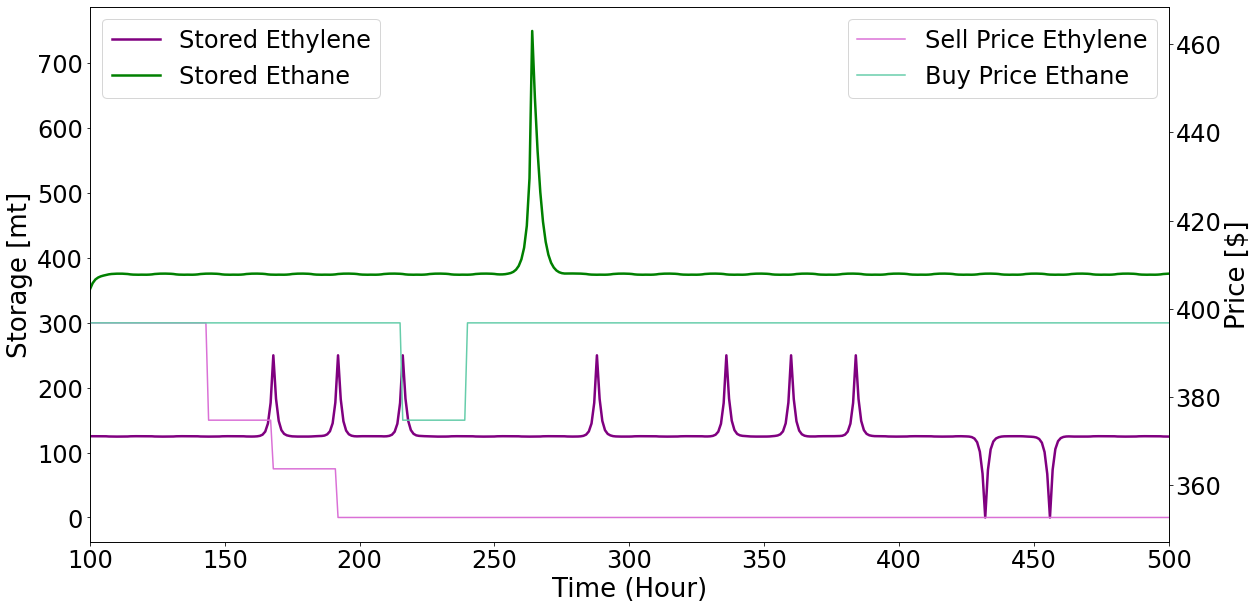

In [27]:
# battery state of charge and electricity price - 
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('State of charge [MWh]')
ax2.set_ylabel('Price [$/MWh]')
# ax.plot(E_b.value, color="orange", label="Stored Energy", linewidth=2.5)
ax2.plot(C_gr, color="red", label="Electricity Price", linestyle='dashed', linewidth=2.5, )
ax.legend(['Stored Energy', 'Electricity Price'], loc='upper left')
ax2.legend(['Price ($/MWh)'], loc='upper right')
plt.tight_layout()
#plt.title("Battery state of charge and wholesale electricity prices")
ax.set_xlim([100, 500])
# ax.set_ylim([-5, max(E_b.value)+10])
plt.show()
fig, ax = plt.subplots(figsize=(18,9))
ax2 = ax.twinx()
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Storage [mt]')
ax2.set_ylabel('Price [$]')
ax.plot(St_e_j, color="purple", label="Stored Ethylene", linewidth=2.5)
ax.plot(St_f_j, color="green", label="Stored Ethane", linewidth=2.5)
ax2.plot(S_p_e, color="orchid", label="Sell Price Ethylene")
ax2.plot(B_p, color="mediumaquamarine", label="Buy Price Ethane")
ax.legend(['Stored Ethylene', 'Stored Ethane'], loc='upper left')
ax2.legend(['Sell Price Ethylene', 'Buy Price Ethane'], loc='upper right')
plt.tight_layout()
#plt.title("Stored Ethane and Ethylene and Buy/Sell Prices")
ax.set_xlim([100, 500])
plt.show()

# Plotting

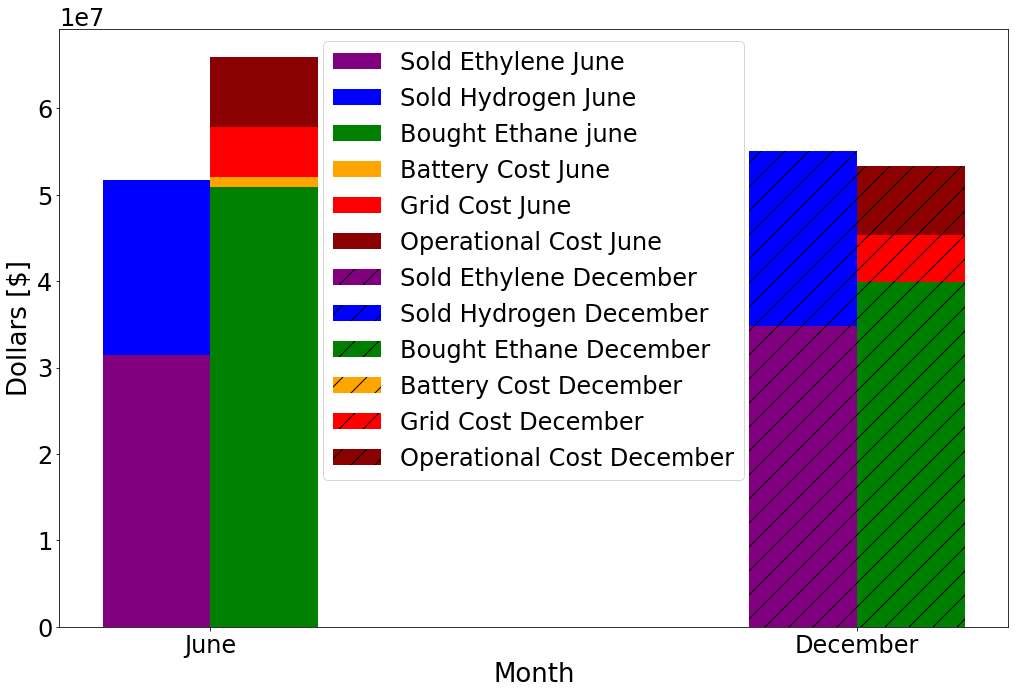

In [28]:
from pylab import *
fig, ax = plt.subplots(figsize=(17,11))
width = 0.5

ax.bar(0, sum(S_l_e_j), width, color="purple", align='edge', label="Sold Ethylene June")
ax.bar(0, sum(S_l_h_j), width, color="blue", align='edge', bottom=sum(S_l_e_j), label="Sold Hydrogen June")
ax.bar(0.5, sum(P_c_j)*pc_multiplier, width, color="green", align='edge', label="Bought Ethane june")
# ax.bar(0.5, (C_s_j), width, color="gold", align='edge', bottom=sum(P_c_j)*pc_multiplier, label="solar cost june")
ax.bar(0.5, (C_b_j), width, color="orange", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j, label="Battery Cost June")
ax.bar(0.5, sum(C_g_j), width, color="red", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j, label="Grid Cost June")
ax.bar(0.5, op_c*sum(Pd_e_j), width, color="darkred", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j+sum(C_g_j), label="Operational Cost June")

ax.bar(3, sum(S_l_e_d), width, color="purple", hatch='/', align='edge', label="Sold Ethylene December")
ax.bar(3, sum(S_l_h_d), width, color="blue", hatch='/', align='edge', bottom=sum(S_l_e_d), label="Sold Hydrogen December")
ax.bar(3.5, sum(P_c_d)*pc_multiplier, width, color="green", hatch='/', align='edge', label="Bought Ethane December")
# ax.bar(2.5, (C_s_d), width, color="gold", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier, label="solar cost december")
ax.bar(3.5, (C_b_d), width, color="orange", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d, label="Battery Cost December")
ax.bar(3.5, sum(C_g_d), width, color="red", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d, label="Grid Cost December")
ax.bar(3.5, op_c*sum(Pd_e_d), width, color="darkred", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d+sum(C_g_d), label="Operational Cost December")

ax.set_ylabel('Dollars [$]')
ax.set_xlabel('Month')

x1 = [0.5,3.5]
labels = ['June', 'December']
ax.set_xticks(x1)
ax.set_xticklabels(labels, minor=False)

# ax.set_title('Monthly Revenue and Costs')
ax.legend(loc="upper center")
plt.show()

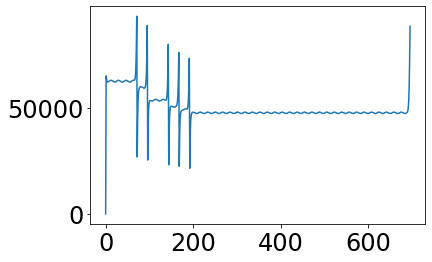

In [29]:
plt.plot(S_l_e_d)

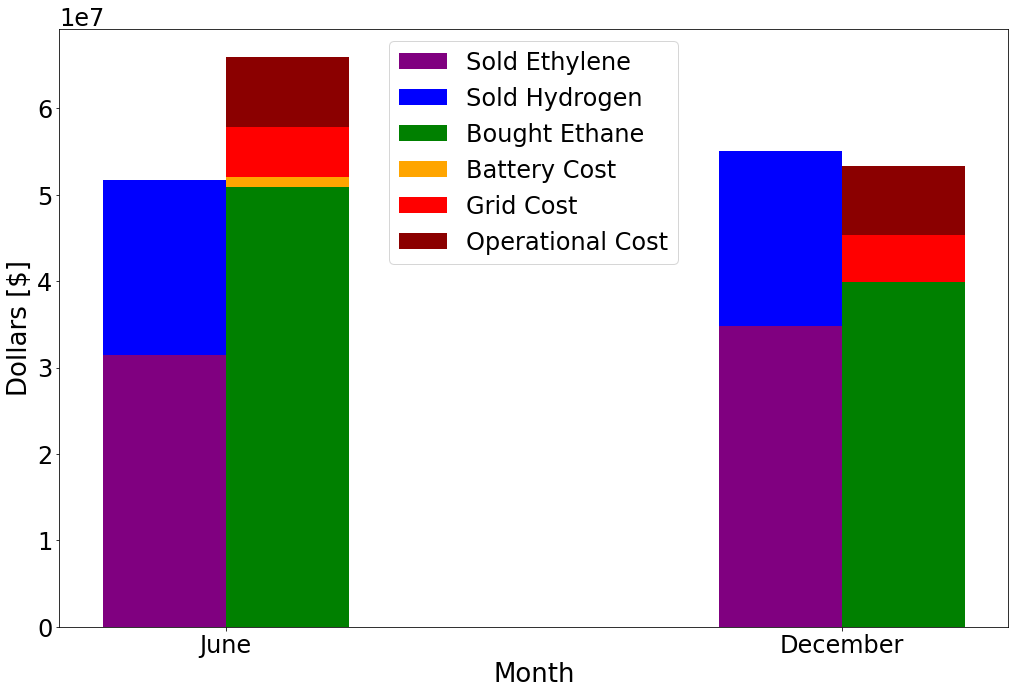

In [30]:
from pylab import *
fig, ax = plt.subplots(figsize=(17,11))
width = 0.5

ax.bar(0, sum(S_l_e_j), width, color="purple", align='edge', label="Sold Ethylene")
ax.bar(0, sum(S_l_h_j), width, color="blue", align='edge', bottom=sum(S_l_e_j), label="Sold Hydrogen")
ax.bar(0.5, sum(P_c_j)*pc_multiplier, width, color="green", align='edge', label="Bought Ethane")
# ax.bar(0.5, (C_s_j), width, color="gold", align='edge', bottom=sum(P_c_j)*pc_multiplier, label="solar cost june")
ax.bar(0.5, (C_b_j), width, color="orange", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j, label="Battery Cost")
ax.bar(0.5, sum(C_g_j), width, color="red", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j, label="Grid Cost")
ax.bar(0.5, op_c*sum(Pd_e_j), width, color="darkred", align='edge', bottom=sum(P_c_j)*pc_multiplier+C_s_j+C_b_j+sum(C_g_j), label="Operational Cost")

ax.bar(2.5, sum(S_l_e_d), width, color="purple", align='edge')
ax.bar(2.5, sum(S_l_h_d), width, color="blue", align='edge', bottom=sum(S_l_e_d))
ax.bar(3, sum(P_c_d)*pc_multiplier, width, color="green", align='edge')
# ax.bar(2.5, (C_s_d), width, color="gold", hatch='/', align='edge', bottom=sum(P_c_d)*pc_multiplier, label="solar cost december")
ax.bar(3, (C_b_d), width, color="orange", align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d)
ax.bar(3, sum(C_g_d), width, color="red", align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d)
ax.bar(3, op_c*sum(Pd_e_d), width, color="darkred",  align='edge', bottom=sum(P_c_d)*pc_multiplier+C_s_d+C_b_d+sum(C_g_d))

ax.set_ylabel('Dollars [$]')
ax.set_xlabel('Month')

x1 = [0.5,3]
labels = ['June', 'December']
ax.set_xticks(x1)
ax.set_xticklabels(labels, minor=False)

# ax.set_title('Monthly Revenue and Costs')
ax.legend(loc="upper center")
plt.show()